In [1]:
from IPython.display import HTML, Image

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Volt-VAR Analysis Plots

#### This notebook uses MW, MVAR, and kV data from 7 substations:
Section A (High Volume of Time With Voltage and VAR Violations):
1. La Cienega
2. Rector
3. Saugus
4. Windhub

Section B (Limited Volume of Time With Voltage and VAR Violation):
1. Johanna

Section C (Temporary Voltage and VAR Violation):
1. Springville
2. Villa Park

#### from the period January 1, 2016 00:00:00 to March 31, 2017 23:59:00 (and any time in between).

**Notes:**
1. The SOB-17's are provided beneath each substation name for reference.
2. The definition of a violation is:
    * MVAR: Outside the SOB-17 range for the given MW load
    * Voltage: Outside the arbitrary 2% boundary from the reference voltage
3. 2% boundaries for Voltage plots are chosen arbitrarily (if band/range specified in SOB-17, used the band instead)
4. March 13, 2016 - 02:00:00 -> 03:00:00 (Daylight Savings Time)
    * System uses Pacific Standard Time (PST) so there is a 1 hour gap in the data
    * To incorporate this "missing" time:
        * I set those missing data points to be the average of the adjacent values before and after the missing time period (March 13, 2016 - 01:59:00 and March 13, 2016 - 03:01:00)
        * I did not plot that data (so there will be a gap in the plots during that time with no points
5. For some outlier points (where the reading was 0, most likely due to measurement error), I set them to the reference voltage/VAR only for the purpose of ignoring them when determining violations.

# 1. Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import random

In [4]:
# read input from excel file
table = pd.read_excel('VoltVarSummaryData.xlsx', 'Summary')
print("Read data from VoltVarSummaryData.xlsx")

Read data from VoltVarSummaryData.xlsx


In [5]:
datetimes = [pd.to_datetime(table.at[i, "Date"]) for i in range(656640)]
for i in range(656640):
    datetimes[i] = datetimes[i].replace(hour=table.at[i, "Time"].hour, minute=table.at[i, "Time"].minute)

In [6]:
startTime = datetimes[0].replace(hour=table.at[0, "Time"].hour, minute=table.at[0, "Time"].minute)

def computeTableIndex(datetimeObject):
    return int((datetimeObject - startTime).total_seconds() // 60)

def MaxMonthlyViolation(dates, start, end, actual, high, low, include_non_violations=True):
    """
    This function finds the month where there was the greatest total amount of violation.
    
    INPUT:
        dates: array of dates and times aligned with the data arrays
        start: index of the starting date as computed by computeTableIndex
        end: index of the ending date as computed by computeTableIndex
        actual: actual MVAR load or kV data
        high: upper boundary on MVAR load or kV data range
        low: lower boundary on MVAR load or kV data range
        include_non_violations: boolean whether or not to include non-violations (as 0's) in data
    
    OUTPUT:
        list of means of violation in each month
    """   
    # Initialize a dictionary, January 2016 = 0, March 2017 = 15
    violations = {}
    for relative_month in range(15):
        current_month = datetime(2016 + relative_month // 12, (relative_month % 12) + 1, 1).strftime("%m/%Y")
        violations[current_month] = []
    
    # Fill the respective arrays with violations
    for date_index in range(start, end + 1):
        max_value = high[date_index]
        min_value = low[date_index]
        value = actual[date_index]
        
        current_month = dates[date_index].strftime("%m/%Y")
        
        if value > max_value or value < min_value:
            violations[current_month].append(max(value - max_value, min_value - value))
        else:
            if include_non_violations:
                violations[current_month].append(0)
    
    # Compute the medians of each array as a representative value of the dataset
    for key, arr in violations.items():
        if len(arr) != 0:
            violations[key] = np.median(arr)
        else:
            violations[key] = 0
    return violations

def MaxDailyViolation(dates, start, end, actual, high, low, include_non_violations=True):
    """
    This function finds the day where there was the greatest total amount of violation.
    
    INPUT:
        dates: array of dates and times aligned with the data arrays
        start: index of the starting date as computed by computeTableIndex
        end: index of the ending date as computed by computeTableIndex
        actual: actual MVAR load or kV data
        high: upper boundary on MVAR load or kV data range
        low: lower boundary on MVAR load or kV data range
        include_non_violations: boolean whether or not to include non-violations (as 0's) in data
    
    OUTPUT:
        list of means of violation in each day
    """
    # Initialize a dictionary; Monday = 0, Sunday = 6
    days_dict = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
    violations = {}
    for day_num, day_name in days_dict.items():
        violations[day_name] = []
    
    # Fill the respective arrays with violations
    for date_index in range(start, end + 1):
        max_value = high[date_index]
        min_value = low[date_index]
        value = actual[date_index]
        
        day_num = dates[date_index].weekday()
        day_name = days_dict[day_num]
        
        if value > max_value or value < min_value:
            violations[day_name].append(max(value - max_value, min_value - value))
        else:
            if include_non_violations:
                violations[day_name].append(0)

    # Compute the medians of each array as a representative value of the dataset
    for key, arr in violations.items():
        if len(arr) != 0:
            violations[key] = np.median(arr)
        else:
            violations[key] = 0
    return violations

def MaxHourlyViolation(dates, start, end, actual, high, low, include_non_violations=True):
    """
    This function finds the hour of the day where there was the greatest total amount of violation.
    
    INPUT:
        dates: array of dates and times aligned with the data arrays
        start: index of the starting date as computed by computeTableIndex
        end: index of the ending date as computed by computeTableIndex
        actual: actual MVAR load or kV data
        high: upper boundary on MVAR load or kV data range
        low: lower boundary on MVAR load or kV data range
        include_non_violations: boolean whether or not to include non-violations (as 0's) in data
    
    OUTPUT:
        list of means of violation in each hour
    """
    # Initialize a dictionary; 0 = 00:00, 23 = 23:00
    violations = {}
    for hour in range(24):
        violations[hour] = []
    
    # Fill the respective arrays with violations
    for date_index in range(start, end + 1):
        max_value = high[date_index]
        min_value = low[date_index]
        value = actual[date_index]
        
        current_hour = dates[date_index].hour
        
        if value > max_value or value < min_value:
            violations[current_hour].append(max(value - max_value, min_value - value))
        else:
            if include_non_violations:
                violations[current_hour].append(0)
    
    # Compute the medians of each array as a representative value of the dataset
    for key, arr in violations.items():
        if len(arr) != 0:
            violations[key] = np.median(arr)
        else:
            violations[key] = 0
    return violations

In [37]:
def plotMW(station_name, dates, MW_load, start, end):
    """
    Plots the MW load on the bank against time.
    
    INPUT:
        station_name: (String) name of substation to plot
        dates: (List) list of datetime objects incremented every minute
        MW_load: (List) list of MW-load values corresponding to the list of dates
        start: (Integer) index of where in the dates and MW_load list to start plotting
        end: (Integer) index of where in the dates and MW_load list to stop plotting
    """
    
    plt.figure(figsize=(18,5))
    plt.title(station_name + " MW")
    plt.xlabel("Date")
    plt.ylabel("MW")
    plt.grid(True)

    if start <= LeftDSTGap and end <= LeftDSTGap and end > start:
        plt.scatter(dates[start: end], MW_load[start: end], 1, 'lightgreen', label='MW Load')
    elif start <= LeftDSTGap and end > LeftDSTGap and end <= RightDSTGap:
        plt.scatter(dates[start: LeftDSTGap + 1], MW_load[start: LeftDSTGap + 1], 1, 'lightgreen', label='MW Load')
    elif start <= LeftDSTGap and end > RightDSTGap:
        plt.scatter(dates[start: LeftDSTGap + 1] + dates[RightDSTGap: end], MW_load[start: LeftDSTGap + 1] + MW_load[RightDSTGap: end], 1, 'lightgreen', label='MW Load')
    elif start > LeftDSTGap and start <= RightDSTGap and end > RightDSTGap:
        plt.scatter(dates[RightDSTGap: end], MW_load[RightDSTGap: end], 1, 'lightgreen', label='MW Load')
    elif start > RightDSTGap and end > RightDSTGap and end > start:
        plt.scatter(dates[start: end], MW_load[start: end], 1, 'lightgreen', label='MW Load')

    plt.legend(loc='lower right')
    plt.show()

def plotMVAR(station_name, dates, MW_load, MVAR_load, start, end, boundaries):
    """
    Plots the MVAr load on the bank against time.
    
    INPUT:
        station_name: (String) name of substation to plot
        dates: (List) list of datetime objects incremented every minute
        MW_load: (List) list of MW-load values corresponding to the list of dates
        MVAR_load: (List) list of MVAR-load values corresponding to the list of dates
        start: (Integer) index of where in the dates and MVAR_load list to start plotting
        end: (Integer) index of where in the dates and MVAR_load list to stop plotting
        boundaries: (List) list of tuples (low_MW, high_MW, low_MVAR, high_MVAR)
    
    OUTPUT:
        lower: (List) lower boundary for the voltage (for use as parameter to plotBreakdown(...))
        upper: (List) upper boundary for the voltage (for use as parameter to plotBreakdown(...))
    """
    
    plt.figure(figsize=(18,5))
    plt.title(station_name + " MVAR")
    plt.xlabel("Date")
    plt.ylabel("MVAR")
    plt.grid(True)

    if start <= LeftDSTGap and end <= LeftDSTGap and end > start:
        plt.scatter(dates[start: end], MVAR_load[start: end], 1, 'lightgreen', label='MVAR Load')
    elif start <= LeftDSTGap and end > LeftDSTGap and end <= RightDSTGap:
        plt.scatter(dates[start: LeftDSTGap + 1], MVAR_load[start: LeftDSTGap + 1], 1, 'lightgreen', label='MVAR Load')
    elif start <= LeftDSTGap and end > RightDSTGap:
        plt.scatter(dates[start: LeftDSTGap + 1] + dates[RightDSTGap: end], MVAR_load[start: LeftDSTGap + 1] + MVAR_load[RightDSTGap: end], 1, 'lightgreen', label='MVAR Load')
    elif start > LeftDSTGap and start <= RightDSTGap and end > RightDSTGap:
        plt.scatter(dates[RightDSTGap: end], MVAR_load[RightDSTGap: end], 1, 'lightgreen', label='MVAR Load')
    elif start > RightDSTGap and end > RightDSTGap and end > start:
        plt.scatter(dates[start: end], MVAR_load[start: end], 1, 'lightgreen', label='MVAR Load')

    lower = []
    upper = []
    for i in range(end - start + 1):
        load = MW_load[start + i]
        
        if load < 0:
            lower.append(0)
            upper.append(0)
        
        for bound in boundaries:
            low_MW = bound[0]
            high_MW = bound[1] if len(bound) == 4 else float('inf')
            low_MVAR = bound[2] if len(bound) == 4 else bound[1]
            high_MVAR = bound[3] if len(bound) == 4 else bound[2]
            
            if load >= low_MW and load < high_MW:
                upper.append(high_MVAR)
                lower.append(low_MVAR)
                break

    plt.plot(dates[start: end + 1], upper, 'r--', label='Upper Boundary')
    plt.plot(dates[start: end + 1], lower, 'b--', label='Lower Boundary')

    plt.legend(loc='lower right')
    plt.show()
    
    return lower, upper

def plotVoltage(station_name, dates, MW_load, Voltage, start, end, boundaries, bound_type):
    """
    Plots the voltage across the bank against time.
    
    INPUT:
        station_name: (String) name of substation to plot
        dates: (List) list of datetime objects incremented every minute
        MW_load: (List) list of MW-load values corresponding to the list of dates
        Voltage: (List) list of Voltage values corresponding to the list of dates
        start: (Integer) index of where in the dates and Voltage list to start plotting
        end: (Integer) index of where in the dates and Voltage list to stop plotting
        boundaries: Dependent on bound_type as follows
                "all times" - (Integer) reference voltage
                "range" - (Tuple) tuple of (low_Volt, high_Volt)
                "load dependent" - (List) list of tuples (low_MW, high_MW, reference voltage)
                "load dependent range" - (List) list of tuples (low_MW, high_MW, low_Volt, high_Volt)
        bound_type: (String) designation for the bound type - "all times", "range", "load dependent", "load dependent range"
    
    OUTPUT:
        lower: (List) lower boundary for the voltage (for use as parameter to plotBreakdown(...))
        upper: (List) upper boundary for the voltage (for use as parameter to plotBreakdown(...))
    """

    plt.figure(figsize=(18,5))
    plt.title(station_name + " kV")
    plt.xlabel("Date")
    plt.ylabel("kV")
    plt.grid(True)

    if start <= LeftDSTGap and end <= LeftDSTGap and end > start:
        plt.scatter(dates[start: end], Voltage[start: end], 1, 'lightgreen', label='Voltage')
    elif start <= LeftDSTGap and end > LeftDSTGap and end <= RightDSTGap:
        plt.scatter(dates[start: LeftDSTGap + 1], Voltage[start: LeftDSTGap + 1], 1, 'lightgreen', label='Voltage')
    elif start <= LeftDSTGap and end > RightDSTGap:
        plt.scatter(dates[start: LeftDSTGap + 1] + dates[RightDSTGap: end], Voltage[start: LeftDSTGap + 1] + Voltage[RightDSTGap: end], 1, 'lightgreen', label='Voltage')
    elif start > LeftDSTGap and start <= RightDSTGap and end > RightDSTGap:
        plt.scatter(dates[RightDSTGap: end], Voltage[RightDSTGap: end], 1, 'lightgreen', label='Voltage')
    elif start > RightDSTGap and end > RightDSTGap and end > start:
        plt.scatter(dates[start: end], Voltage[start: end], 1, 'lightgreen', label='Voltage')
    
    lower = []
    upper = []
    
    if bound_type == "all times":
        Ref_Voltage = [boundaries for _ in range(end - start + 1)]
        lower = [0.98*Ref_Voltage[i] for i in range(end - start + 1)]
        upper = [1.02*Ref_Voltage[i] for i in range(end - start + 1)]
        plt.plot(dates[start: end + 1], Ref_Voltage, 'k', label='Reference Voltage')
        plt.plot(dates[start: end + 1], upper, 'r--', label='2% Upper Boundary')
        plt.plot(dates[start: end + 1], lower, 'b--', label='2% Lower Boundary')
    elif bound_type == "range":
        low_voltage = boundaries[0]
        high_voltage = boundaries[1]
        lower = [low_voltage for _ in range(end - start + 1)]
        upper = [high_voltage for _ in range(end - start + 1)]
        plt.plot(dates[start: end + 1], upper, 'r--', label='Upper SOB-17 Boundary')
        plt.plot(dates[start: end + 1], lower, 'b--', label='Lower SOB-17 Boundary')
    elif bound_type == "load dependent":
        Ref_Voltage = []
        lower = []
        upper = []
        
        for i in range(end - start + 1):
            load = MW_load[start + i]
            
            if load < 0:
                lower.append(0)
                upper.append(0)
                Ref_Voltage.append(0)
            
            for bound in boundaries:
                low_MW = bound[0]
                high_MW = bound[1]
                ref_volt = bound[2]
                
                if load >= low_MW and load < high_MW:
                    Ref_Voltage.append(ref_volt)
                    lower.append(0.98*ref_volt)
                    upper.append(1.02*ref_volt)
                    break
        plt.plot(dates[start: end + 1], Ref_Voltage, 'k', label='Reference Voltage')
        plt.plot(dates[start: end + 1], upper, 'r--', label='2% Upper Boundary')
        plt.plot(dates[start: end + 1], lower, 'b--', label='2% Lower Boundary')
    elif bound_type == "load dependent range":
        lower = []
        upper = []
        
        for i in range(end - start + 1):
            load = MW_load[start + i]
            
            if load < 0:
                lower.append(0)
                upper.append(0)
            
            for bound in boundaries:
                low_MW = bound[0]
                high_MW = bound[1]
                low_volt = bound[2]
                high_volt = bound[3]
                
                if load >= low_MW and load < high_MW:
                    lower.append(low_volt)
                    upper.append(high_volt)
                    break
        plt.plot(dates[start: end + 1], upper, 'r--', label='Upper SOB-17 Boundary')
        plt.plot(dates[start: end + 1], lower, 'b--', label='Lower SOB-17 Boundary')
    
    plt.legend(loc='lower right')
    plt.show()

    return lower, upper

def plotBreakdown(station_name, dates, MVAR_load, Voltage, start, end, lower_VAR, upper_VAR, lower_Voltage, upper_Voltage):
    """
    Plots the breakdown of violations categorized by month of the year, day of the week, and hour of the day.
    
    Aggregates all violations into a list (no violation means a value of 0) and the median is computed for each
    item in the category.
    
    INPUT:
        station_name: (String) name of substation to plot
        dates: (List) list of datetime objects incremented every minute
        MVAR_load: (List) list of MVAR-load values corresponding to the list of dates
        Voltage: (List) list of Voltage values corresponding to the list of dates
        start: (Integer) index of where in the dates and Voltage list to start plotting
        end: (Integer) index of where in the dates and Voltage list to stop plotting
        lower_VAR: (List) lower boundary for the VAR
        upper_VAR: (List) upper boundary for the VAR
        lower_Voltage: (List) lower boundary for the voltage
        upper_Voltage: (List) upper boundary for the voltage
    """
    
    monthly_VAR = MaxMonthlyViolation(dates, start, end, MVAR_load, upper_VAR, lower_VAR)
    daily_VAR = MaxDailyViolation(dates, start, end, MVAR_load, upper_VAR, lower_VAR)
    hourly_VAR = MaxHourlyViolation(dates, start, end, MVAR_load, upper_VAR, lower_VAR)

    monthly_Voltage = MaxMonthlyViolation(dates, start, end, Voltage, upper_Voltage, lower_Voltage)
    daily_Voltage = MaxDailyViolation(dates, start, end, Voltage, upper_Voltage, lower_Voltage)
    hourly_Voltage = MaxHourlyViolation(dates, start, end, Voltage, upper_Voltage, lower_Voltage)

    Xmonthly_VAR = MaxMonthlyViolation(dates, start, end, MVAR_load, upper_VAR, lower_VAR, False)
    Xdaily_VAR = MaxDailyViolation(dates, start, end, MVAR_load, upper_VAR, lower_VAR, False)
    Xhourly_VAR = MaxHourlyViolation(dates, start, end, MVAR_load, upper_VAR, lower_VAR, False)

    Xmonthly_Voltage = MaxMonthlyViolation(dates, start, end, Voltage, upper_Voltage, lower_Voltage, False)
    Xdaily_Voltage = MaxDailyViolation(dates, start, end, Voltage, upper_Voltage, lower_Voltage, False)
    Xhourly_Voltage = MaxHourlyViolation(dates, start, end, Voltage, upper_Voltage, lower_Voltage, False)

    fig, ax = plt.subplots(12, 1, figsize=(15, 50))
    ax[0].bar(range(len(monthly_VAR)), monthly_VAR.values(), align="center")
    ax[0].set_xticks(range(len(monthly_VAR)))
    ax[0].set_xticklabels(monthly_VAR.keys(), rotation=45)
    ax[0].set_ylabel("MVAR")
    ax[0].set_title(station_name + " Monthly Violation (Median)", fontweight='bold')

    ax[1].bar(range(len(monthly_Voltage)), monthly_Voltage.values(), align="center")
    ax[1].set_xticks(range(len(monthly_Voltage)))
    ax[1].set_xticklabels(monthly_Voltage.keys(), rotation=45)
    ax[1].set_xlabel("Month of the Year")
    ax[1].set_ylabel("kV")

    ax[2].bar(range(len(daily_VAR)), daily_VAR.values(), align="center")
    ax[2].set_xticks(range(len(daily_VAR)))
    ax[2].set_xticklabels(daily_VAR.keys(), rotation=45)
    ax[2].set_ylabel("MVAR")
    ax[2].set_title(station_name + " Daily Violation (Median)", fontweight='bold')

    ax[3].bar(range(len(daily_Voltage)), daily_Voltage.values(), align="center")
    ax[3].set_xticks(range(len(daily_Voltage)))
    ax[3].set_xticklabels(daily_Voltage.keys(), rotation=45)
    ax[3].set_xlabel("Day of the Week")
    ax[3].set_ylabel("kV")

    ax[4].bar(range(len(hourly_VAR)), hourly_VAR.values(), align="center")
    ax[4].set_xticks(range(len(hourly_VAR)))
    ax[4].set_xticklabels(hourly_VAR.keys(), rotation=45)
    ax[4].set_ylabel("MVAR")
    ax[4].set_title(station_name + " Hourly Violation (Median)", fontweight='bold')

    ax[5].bar(range(len(hourly_Voltage)), hourly_Voltage.values(), align="center")
    ax[5].set_xticks(range(len(hourly_Voltage)))
    ax[5].set_xticklabels(hourly_Voltage.keys(), rotation=45)
    ax[5].set_xlabel("Hour of the Day")
    ax[5].set_ylabel("kV")

    ax[6].bar(range(len(Xmonthly_VAR)), Xmonthly_VAR.values(), align="center")
    ax[6].set_xticks(range(len(Xmonthly_VAR)))
    ax[6].set_xticklabels(Xmonthly_VAR.keys(), rotation=45)
    ax[6].set_ylabel("MVAR")
    ax[6].set_title(station_name + " Monthly Violation (Median) (Excluding non-violations)", fontweight='bold')

    ax[7].bar(range(len(Xmonthly_Voltage)), Xmonthly_Voltage.values(), align="center")
    ax[7].set_xticks(range(len(Xmonthly_Voltage)))
    ax[7].set_xticklabels(Xmonthly_Voltage.keys(), rotation=45)
    ax[7].set_xlabel("Month of the Year")
    ax[7].set_ylabel("kV")

    ax[8].bar(range(len(Xdaily_VAR)), Xdaily_VAR.values(), align="center")
    ax[8].set_xticks(range(len(Xdaily_VAR)))
    ax[8].set_xticklabels(Xdaily_VAR.keys(), rotation=45)
    ax[8].set_ylabel("MVAR")
    ax[8].set_title(station_name + " Daily Violation (Median) (Excluding non-violations)", fontweight='bold')

    ax[9].bar(range(len(Xdaily_Voltage)), Xdaily_Voltage.values(), align="center")
    ax[9].set_xticks(range(len(Xdaily_Voltage)))
    ax[9].set_xticklabels(Xdaily_Voltage.keys(), rotation=45)
    ax[9].set_xlabel("Day of the Week")
    ax[9].set_ylabel("kV")

    ax[10].bar(range(len(Xhourly_VAR)), Xhourly_VAR.values(), align="center")
    ax[10].set_xticks(range(len(Xhourly_VAR)))
    ax[10].set_xticklabels(Xhourly_VAR.keys(), rotation=45)
    ax[10].set_ylabel("MVAR")
    ax[10].set_title(station_name + " Hourly Violation (Median) (Excluding non-violations)", fontweight='bold')

    ax[11].bar(range(len(Xhourly_Voltage)), Xhourly_Voltage.values(), align="center")
    ax[11].set_xticks(range(len(Xhourly_Voltage)))
    ax[11].set_xticklabels(Xhourly_Voltage.keys(), rotation=45)
    ax[11].set_xlabel("Hour of the Day")
    ax[11].set_ylabel("kV")

    plt.tight_layout()
    plt.show()

    print("If any of the bars are blank, the median is zero.")

In [17]:
# Compute the table index for the start and end of the DST gap
LeftDSTGap = computeTableIndex(datetime(2016, 3, 13, 1, 59))
RightDSTGap = computeTableIndex(datetime(2016, 3, 13, 3, 0))


# 2. Retrieving Data

In [80]:
# Below values have random floats shuffled in to protect SCE company data.

LaCienega_MW_load = [table.at[i, "La Cienega MW"] + random.uniform(-20, 20) for i in range(656640)]
LaCienega_MVAR_load = [table.at[i, "La Cienega MVAR"] + random.uniform(-20, 20) for i in range(656640)]
LaCienega_Voltage = [table.at[i, "La Cienega kV"] + random.uniform(-20, 20) for i in range(656640)]

Rector_MW_load = [table.at[i, "Rector MW"] + random.uniform(-20, 20) for i in range(656640)]
Rector_MVAR_load = [table.at[i, "Rector MVAR"] + random.uniform(-20, 20) for i in range(656640)]
Rector_Voltage = [table.at[i, "Rector kV"] + random.uniform(-20, 20) + random.uniform(-5, 5) for i in range(656640)]

Saugus_MW_load = [table.at[i, "Saugus MW"] + random.uniform(-20, 20) for i in range(656640)]
Saugus_MVAR_load = [table.at[i, "Saugus MVAR"] + random.uniform(-20, 20) for i in range(656640)]
Saugus_Voltage = [table.at[i, "Saugus kV"] + random.uniform(-20, 20) for i in range(656640)]

Springville_MW_load = [table.at[i, "Springville MW"] + random.uniform(-20, 20) for i in range(656640)]
Springville_MVAR_load = [table.at[i, "Springville MVAR"] + random.uniform(-20, 20) for i in range(656640)]
Springville_Voltage = [table.at[i, "Springville kV"] + random.uniform(-20, 20) for i in range(656640)]

Johanna_MW_load = [table.at[i, "Johanna MW"] + random.uniform(-20, 20) for i in range(656640)]
Johanna_MVAR_load = [table.at[i, "Johanna MVAR"] + random.uniform(-20, 20) for i in range(656640)]
Johanna_Voltage = [table.at[i, "Johanna kV"] + random.uniform(-20, 20) for i in range(656640)]

VillaPark_MW_load = [table.at[i, "Villa Park MW"] + random.uniform(-20, 20) for i in range(656640)]
VillaPark_MVAR_load = [table.at[i, "Villa Park MVAR"] + random.uniform(-20, 20) for i in range(656640)]
VillaPark_Voltage = [table.at[i, "Villa Park kV"] + random.uniform(-20, 20) for i in range(656640)]

Windhub_MW_load = [table.at[i, "Windhub MW"] + random.uniform(-20, 20) for i in range(656640)]
Windhub_MVAR_load = [table.at[i, "Windhub MVAR"] + random.uniform(-20, 20) for i in range(656640)]
Windhub_Voltage = [table.at[i, "Windhub kV"] + random.uniform(-20, 20) for i in range(656640)]

print("Loaded data for Analysis.")

Loaded data for Analysis.


# 3A. Plotting Data (High Volume of Voltage and VAR Violations)

## La Cienega (Voltage Dependent on MW Load)

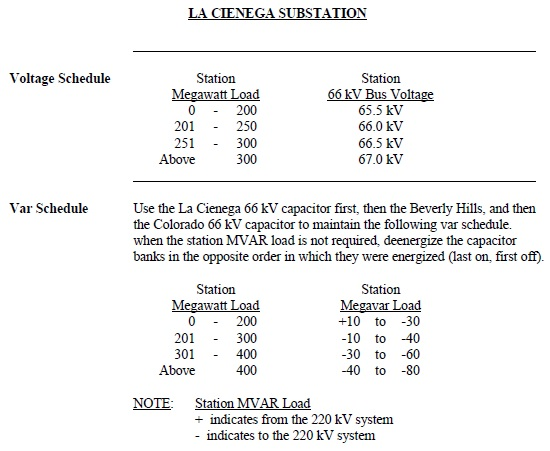

In [81]:
Image("img/LaCienegaSOB.jpg")

In [82]:
start = datetime(2016, 1, 1, 0, 0)
end = datetime(2017, 3, 31, 23, 59)
startDateIndex = computeTableIndex(start)
endDateIndex = computeTableIndex(end)
print("Current Time Period: " + start.strftime('%m/%d/%Y %H:%M') + " to " + end.strftime('%m/%d/%Y %H:%M'))

Current Time Period: 01/01/2016 00:00 to 03/31/2017 23:59


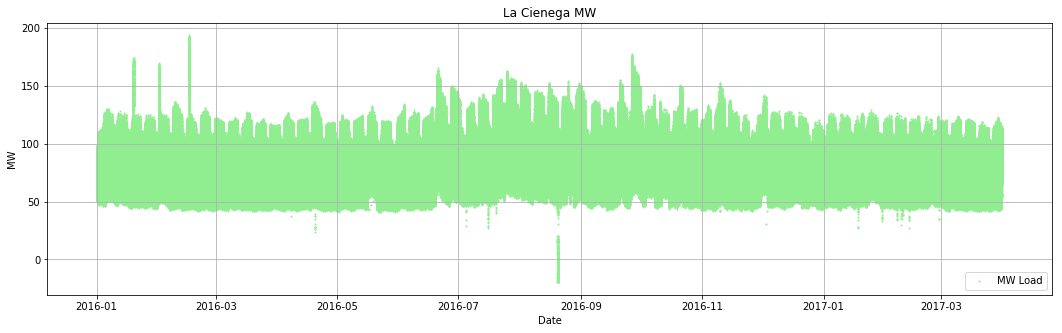

In [83]:
plotMW("La Cienega", datetimes, LaCienega_MW_load, startDateIndex, endDateIndex)

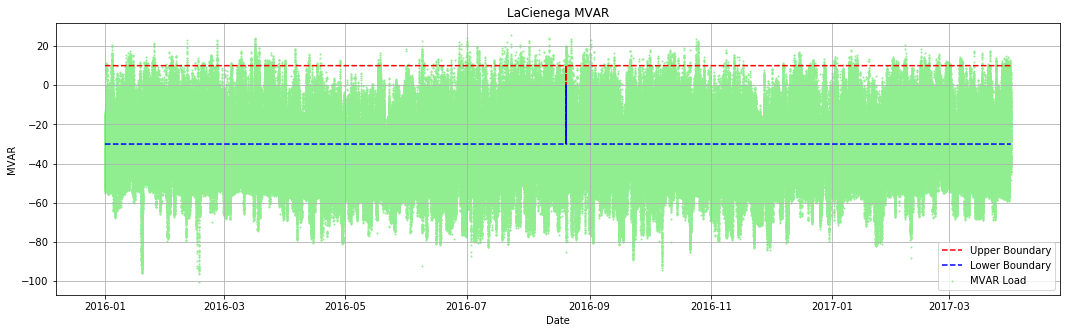

In [84]:
bounds = [(0, 200, -30, 10), (200, 300, -40, -10), (300, 400, -60, -30)]
lower_VAR, upper_VAR = plotMVAR("LaCienega", datetimes, LaCienega_MW_load, LaCienega_MVAR_load, startDateIndex, endDateIndex, bounds)

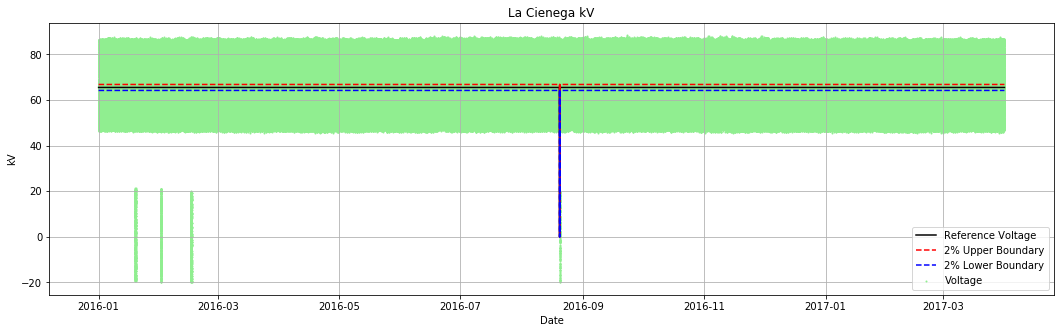

In [85]:
bounds = [(0, 200, 65.5), (200, 250, 66), (250, 300, 66.5), (300, float('inf'), 67)]
lower_Volt, upper_Volt = plotVoltage("La Cienega", datetimes, LaCienega_MW_load, LaCienega_Voltage, startDateIndex, endDateIndex, bounds, "load dependent")

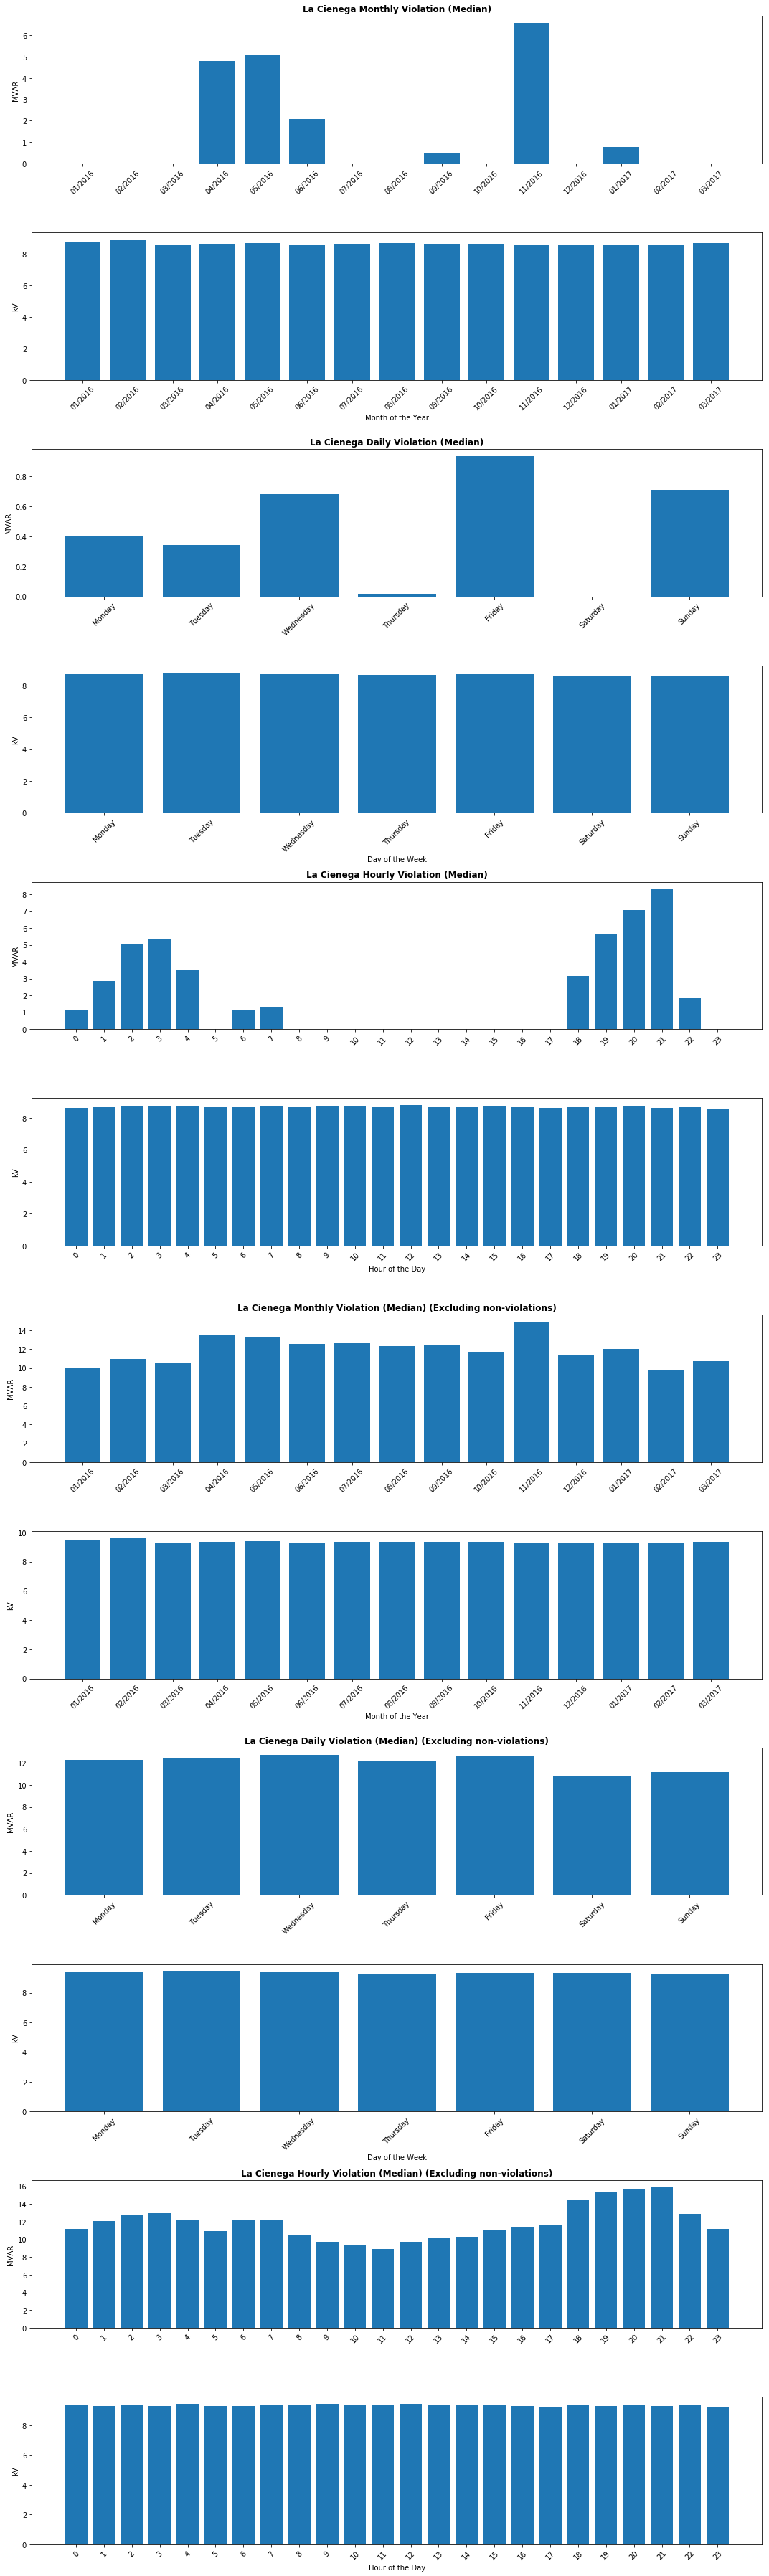

If any of the bars are blank, the median is zero.


In [86]:
plotBreakdown("La Cienega", datetimes, LaCienega_MVAR_load, LaCienega_Voltage, startDateIndex, endDateIndex, lower_VAR, upper_VAR, lower_Volt, upper_Volt)

## Rector (Voltage Dependent on MW Load)

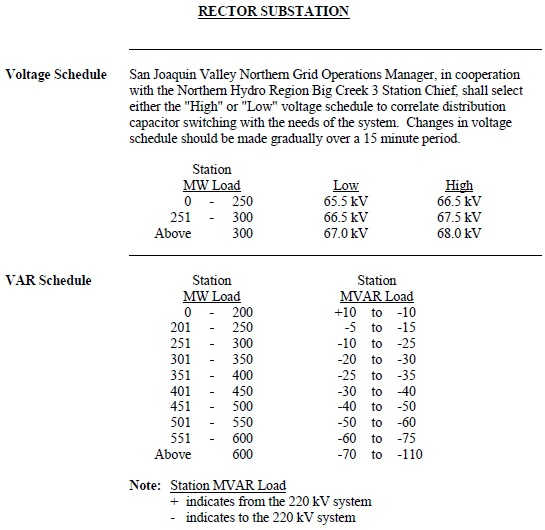

In [87]:
Image("img/RectorSOB.jpg")

In [88]:
start = datetime(2016, 1, 1, 0, 0)
end = datetime(2017, 3, 31, 23, 59)
startDateIndex = computeTableIndex(start)
endDateIndex = computeTableIndex(end)
print("Current Time Period: " + start.strftime('%m/%d/%Y %H:%M') + " to " + end.strftime('%m/%d/%Y %H:%M'))

Current Time Period: 01/01/2016 00:00 to 03/31/2017 23:59


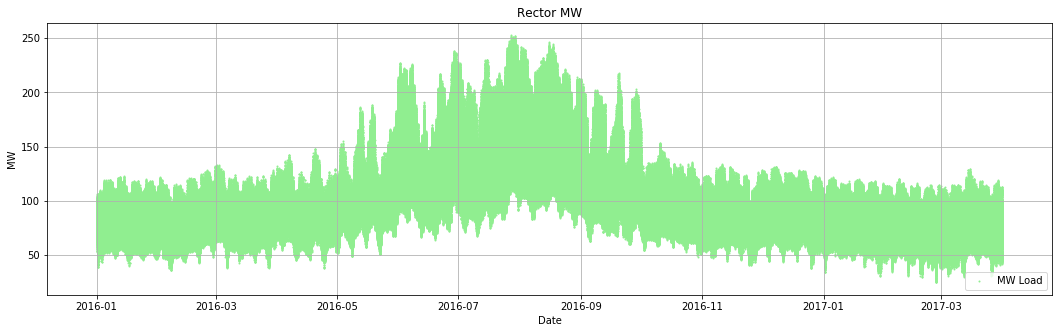

In [89]:
plotMW("Rector", datetimes, Rector_MW_load, startDateIndex, endDateIndex)

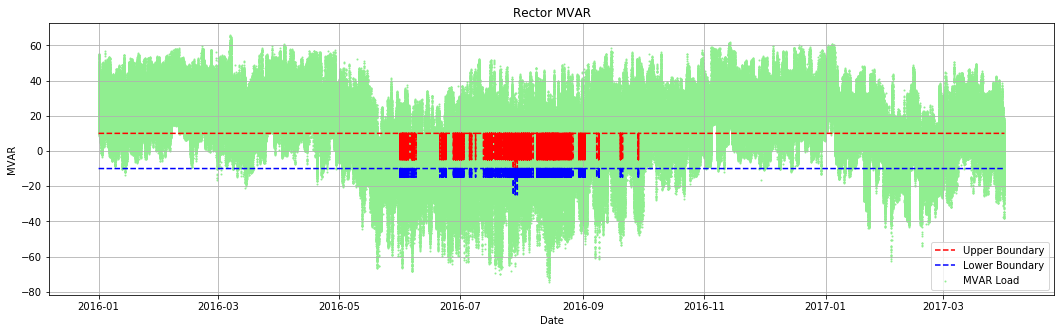

In [90]:
bounds = [(0, 200, -10, 10), (200, 250, -15, -5), (250, 300, -25, -10), (300, 350, -30, -20), (350, 400, -35, -25)]
lower_VAR, upper_VAR = plotMVAR("Rector", datetimes, Rector_MW_load, Rector_MVAR_load, startDateIndex, endDateIndex, bounds)

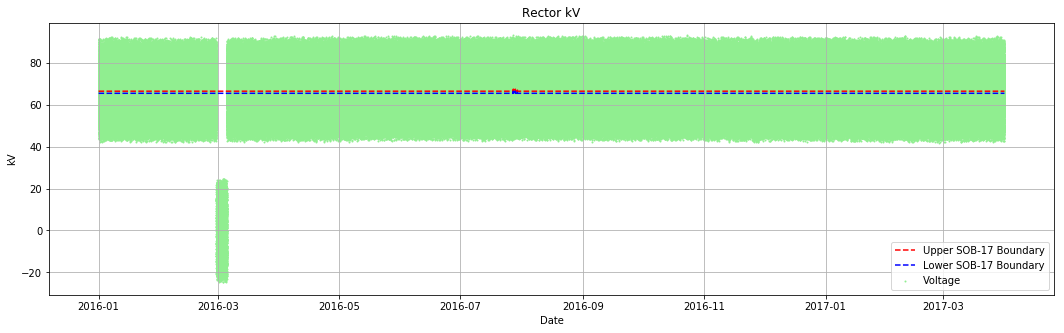

In [91]:
bounds = [(0, 250, 65.5, 66.5), (250, 300, 66.5, 67.5), (300, float('inf'), 67, 68)]
lower_Volt, upper_Volt = plotVoltage("Rector", datetimes, Rector_MW_load, Rector_Voltage, startDateIndex, endDateIndex, bounds, "load dependent range")

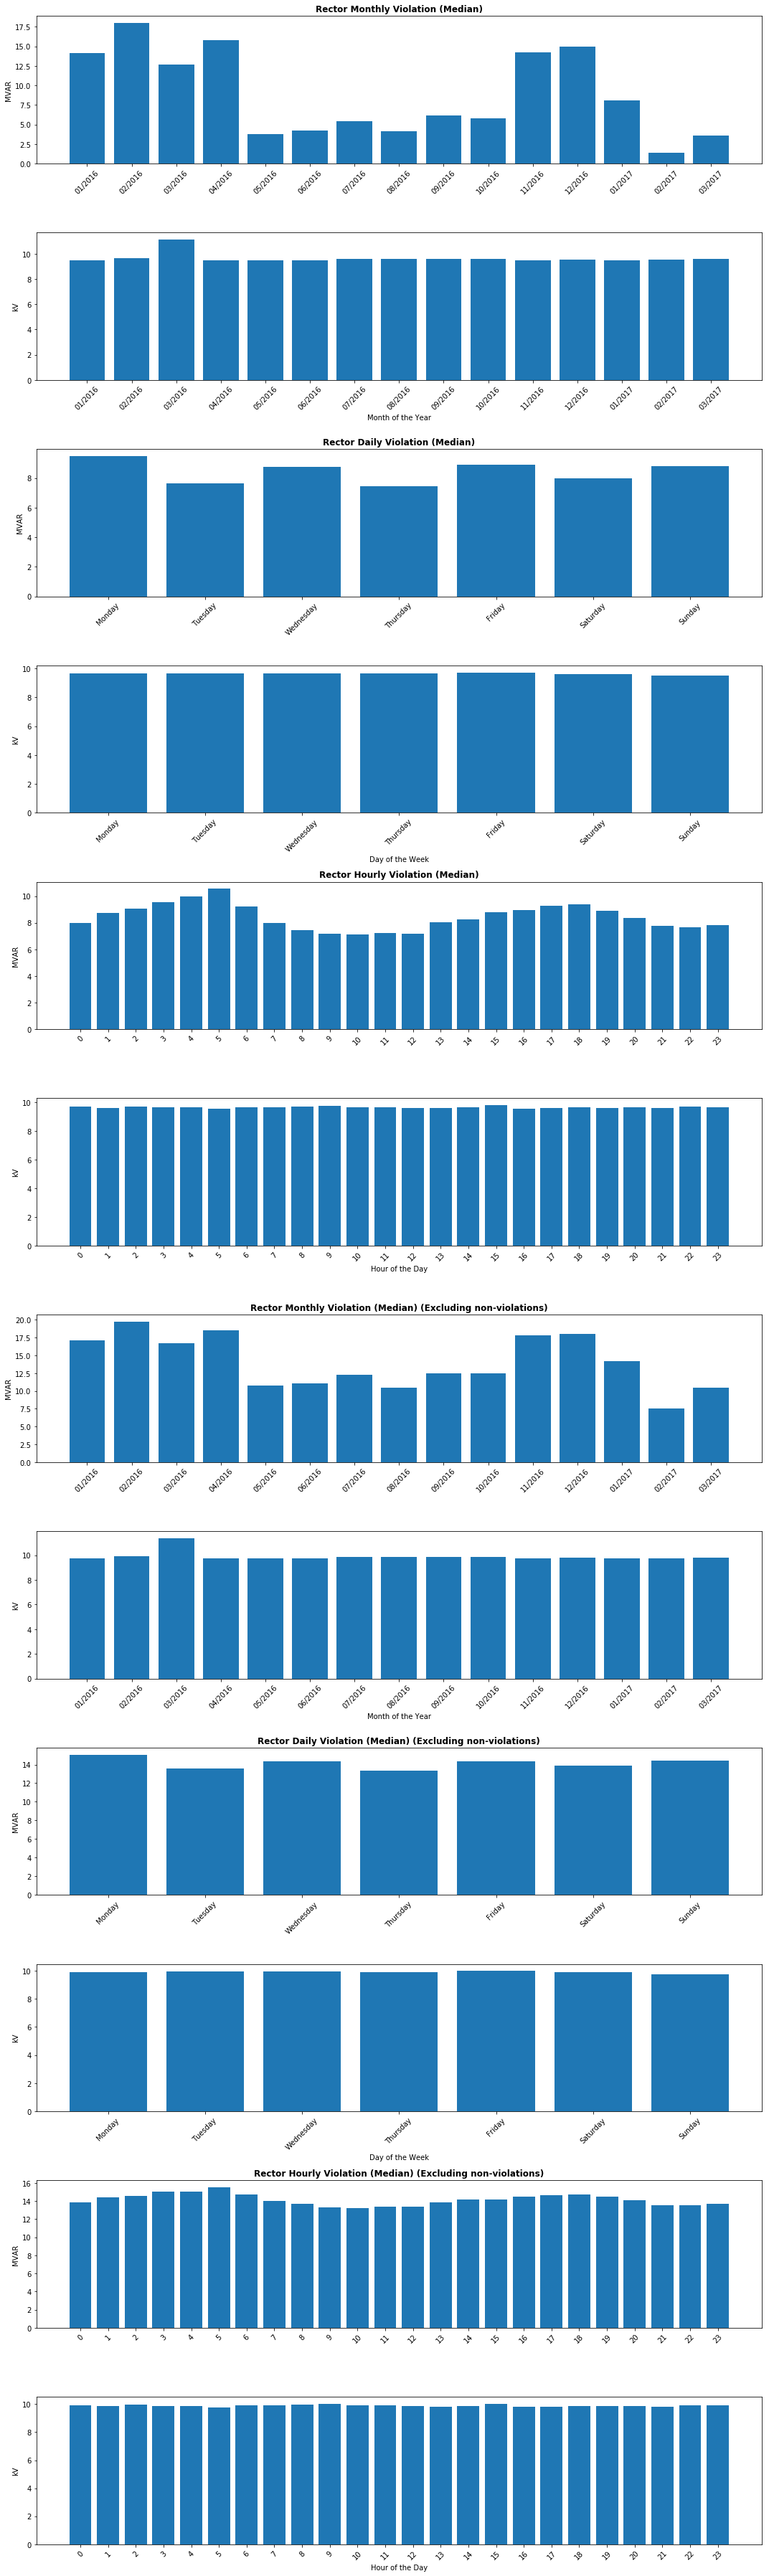

If any of the bars are blank, the median is zero.


In [92]:
plotBreakdown("Rector", datetimes, Rector_MVAR_load, Rector_Voltage, startDateIndex, endDateIndex, lower_VAR, upper_VAR, lower_Volt, upper_Volt)

## Saugus (Voltage Dependent on MW Load)

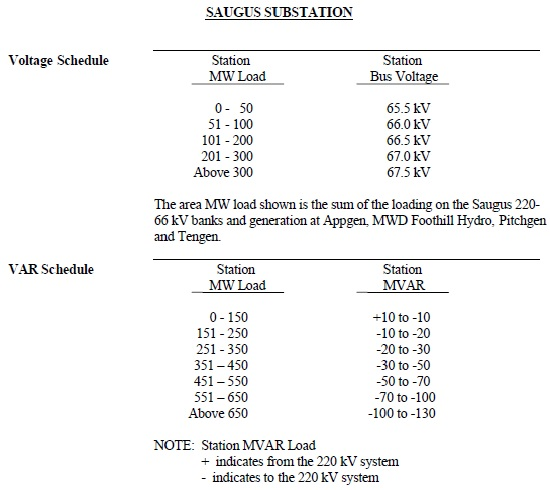

In [93]:
Image("img/SaugusSOB.jpg")

In [94]:
start = datetime(2016, 1, 1, 0, 0)
end = datetime(2017, 3, 31, 23, 59)
startDateIndex = computeTableIndex(start)
endDateIndex = computeTableIndex(end)
print("Current Time Period: " + start.strftime('%m/%d/%Y %H:%M') + " to " + end.strftime('%m/%d/%Y %H:%M'))

Current Time Period: 01/01/2016 00:00 to 03/31/2017 23:59


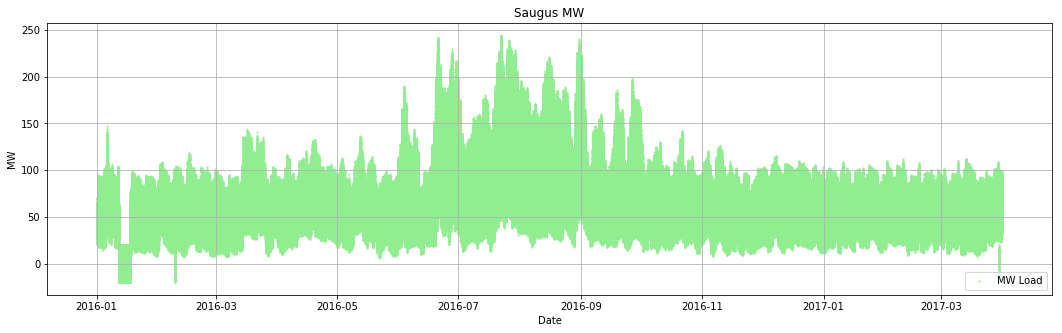

In [95]:
plotMW("Saugus", datetimes, Saugus_MW_load, startDateIndex, endDateIndex)

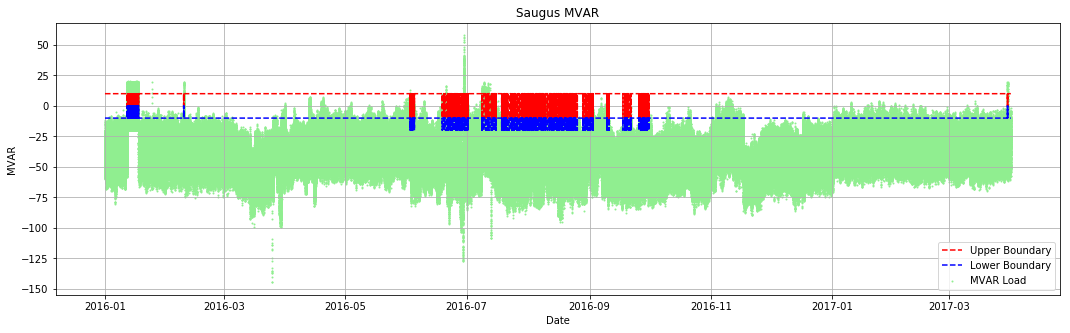

In [96]:
bounds = [(0, 150, -10, 10), (150, 250, -20, -10), (250, 350, -30, -20), (350, 450, -50, -30)]
lower_VAR, upper_VAR = plotMVAR("Saugus", datetimes, Saugus_MW_load, Saugus_MVAR_load, startDateIndex, endDateIndex, bounds)

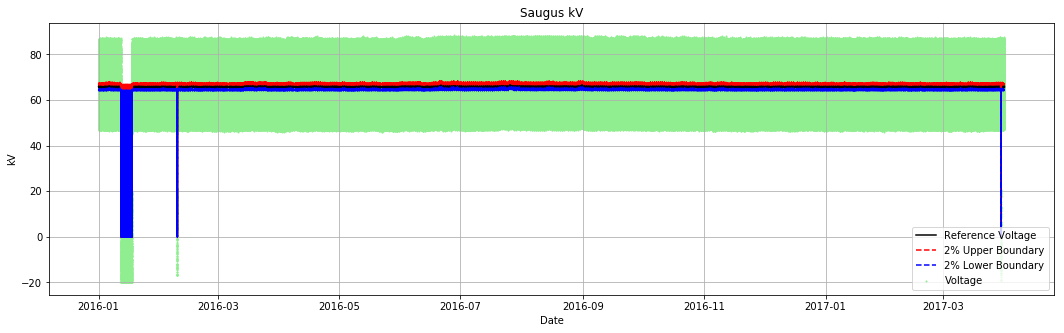

In [97]:
bounds = [(0, 50, 65.5), (50, 100, 66), (100, 200, 66.5), (200, 300, 67), (300, float('inf'), 67.5)]
lower_Volt, upper_Volt = plotVoltage("Saugus", datetimes, Saugus_MW_load, Saugus_Voltage, startDateIndex, endDateIndex, bounds, "load dependent")

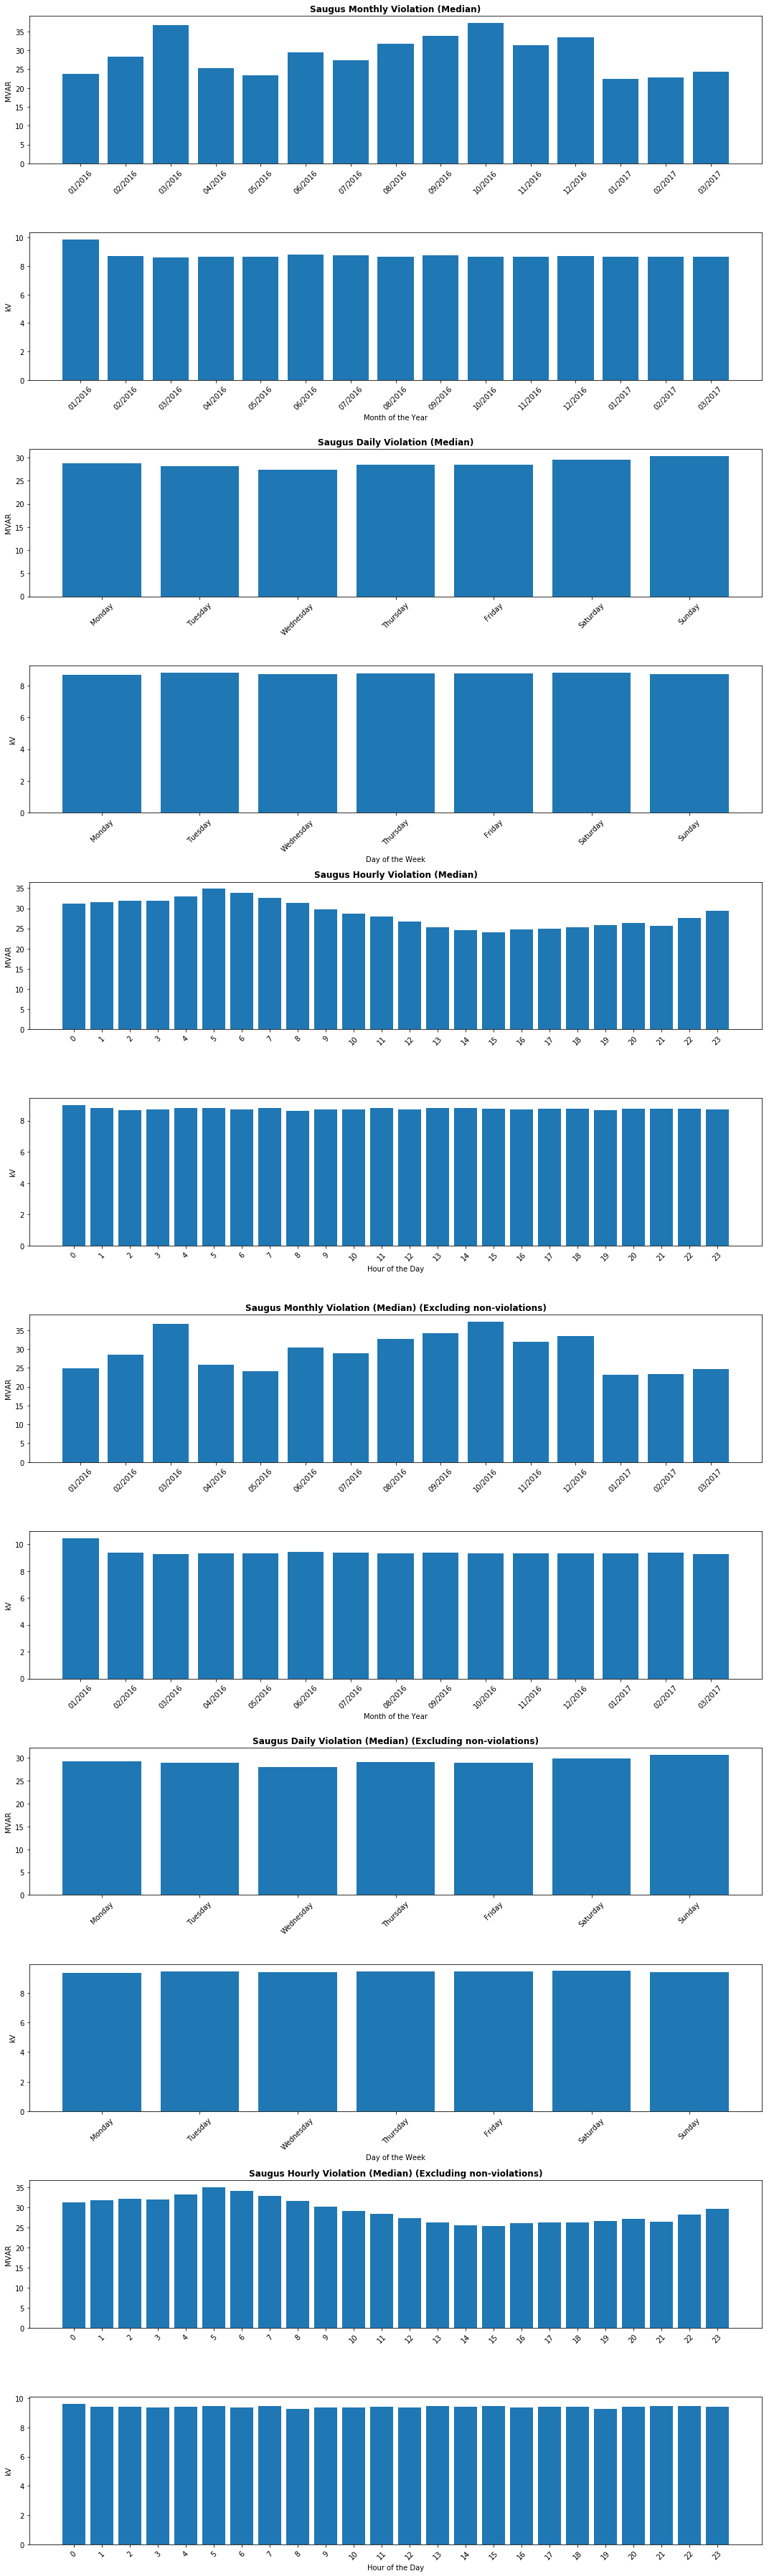

If any of the bars are blank, the median is zero.


In [98]:
plotBreakdown("Saugus", datetimes, Saugus_MVAR_load, Saugus_Voltage, startDateIndex, endDateIndex, lower_VAR, upper_VAR, lower_Volt, upper_Volt)

## Windhub (Voltage Constant Relative to MW Load)

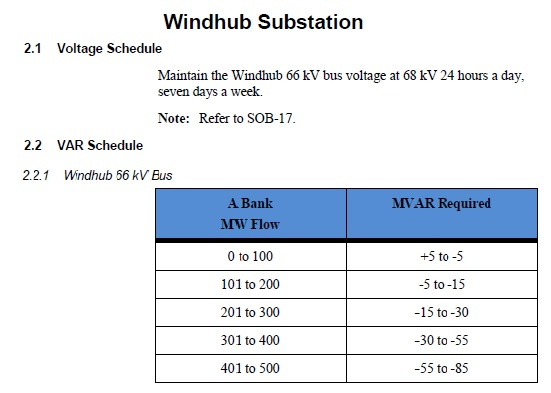

In [99]:
Image("img/WindhubSOB.jpg")

In [100]:
start = datetime(2016, 1, 1, 0, 0)
end = datetime(2017, 3, 31, 23, 59)
startDateIndex = computeTableIndex(start)
endDateIndex = computeTableIndex(end)
print("Current Time Period: " + start.strftime('%m/%d/%Y %H:%M') + " to " + end.strftime('%m/%d/%Y %H:%M'))

Current Time Period: 01/01/2016 00:00 to 03/31/2017 23:59


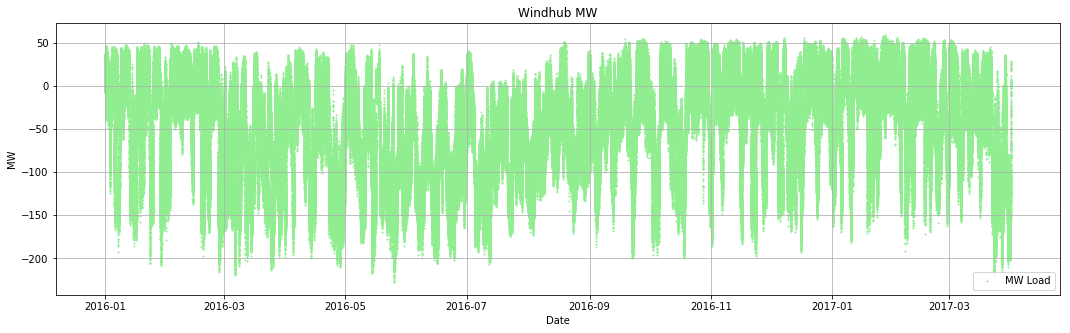

In [101]:
plotMW("Windhub", datetimes, Windhub_MW_load, startDateIndex, endDateIndex)

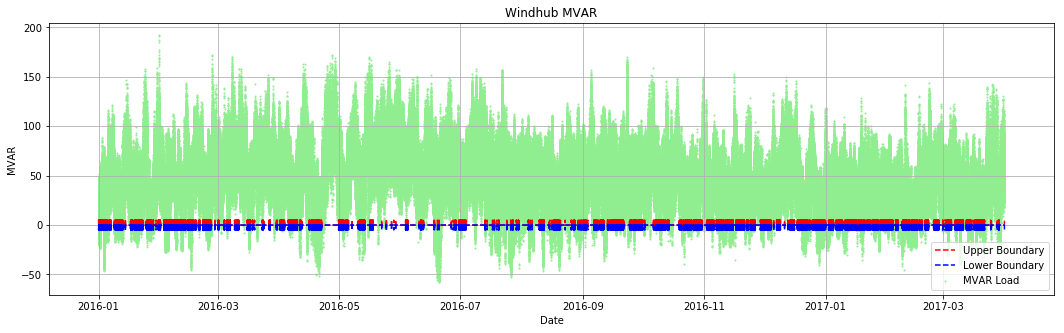

In [102]:
bounds = [(0, 100, -5, 5), (100, 200, -15, -5), (200, 300, -30, -15)]
lower_VAR, upper_VAR = plotMVAR("Windhub", datetimes, Windhub_MW_load, Windhub_MVAR_load, startDateIndex, endDateIndex, bounds)

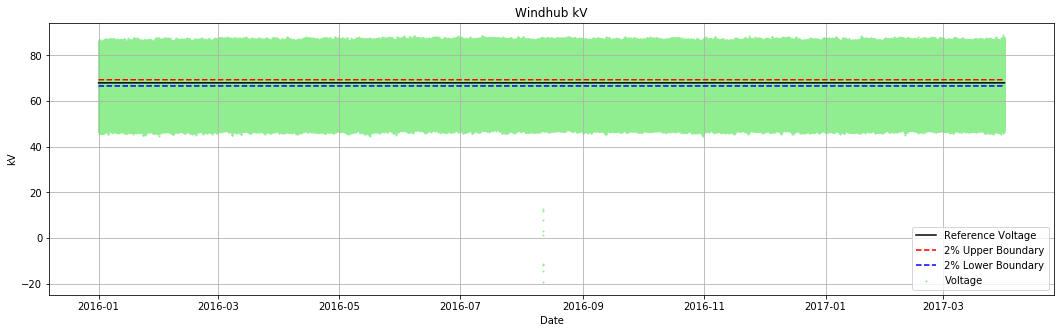

In [103]:
bounds = 68
lower_Volt, upper_Volt = plotVoltage("Windhub", datetimes, Windhub_MW_load, Windhub_Voltage, startDateIndex, endDateIndex, bounds, "all times")

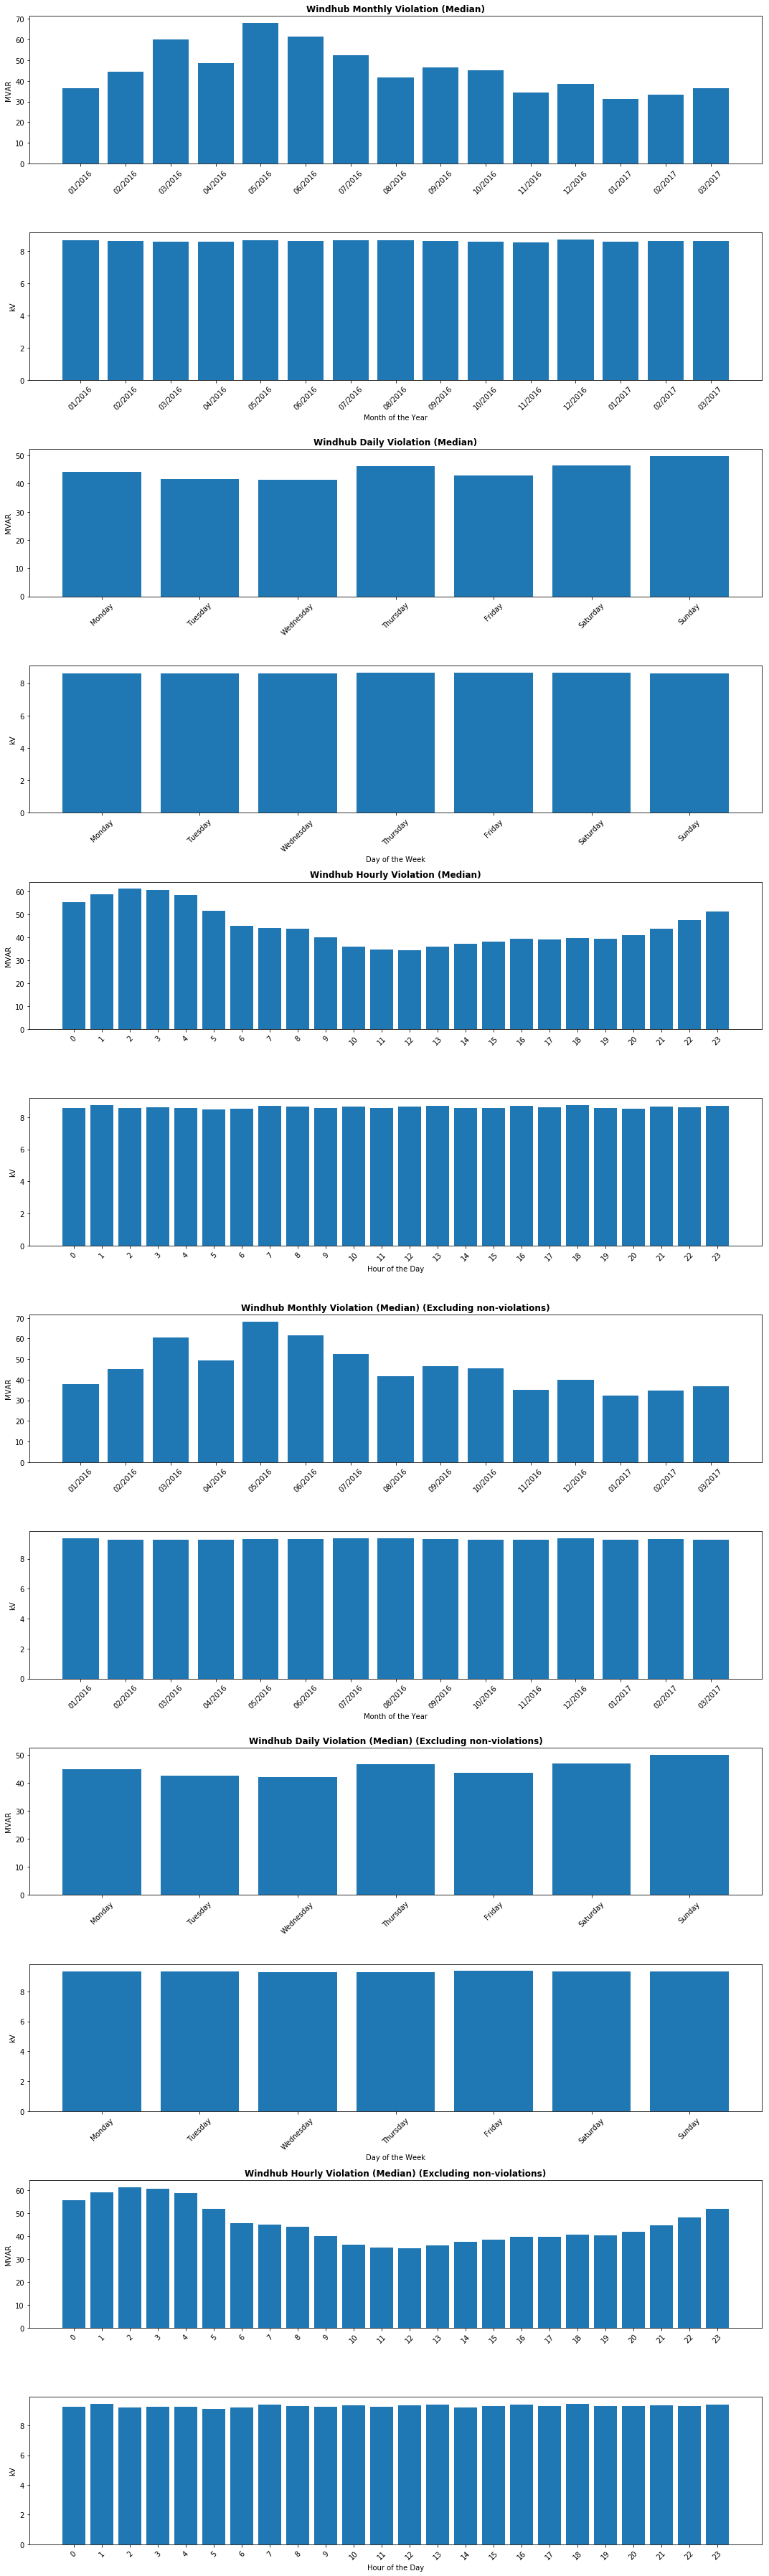

If any of the bars are blank, the median is zero.


In [104]:
plotBreakdown("Windhub", datetimes, Windhub_MVAR_load, Windhub_Voltage, startDateIndex, endDateIndex, lower_VAR, upper_VAR, lower_Volt, upper_Volt)

# 3B. Plotting Data (Limited Voltage or VAR violation)

## Johanna (Voltage Constant Relative to MW Load)

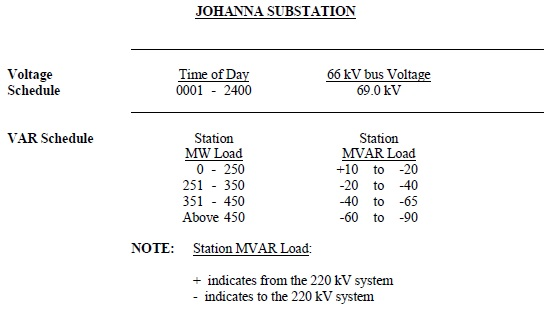

In [105]:
Image("img/JohannaSOB.jpg")

In [106]:
start = datetime(2016, 1, 1, 0, 0)
end = datetime(2017, 3, 31, 23, 59)
startDateIndex = computeTableIndex(start)
endDateIndex = computeTableIndex(end)
print("Current Time Period: " + start.strftime('%m/%d/%Y %H:%M') + " to " + end.strftime('%m/%d/%Y %H:%M'))

Current Time Period: 01/01/2016 00:00 to 03/31/2017 23:59


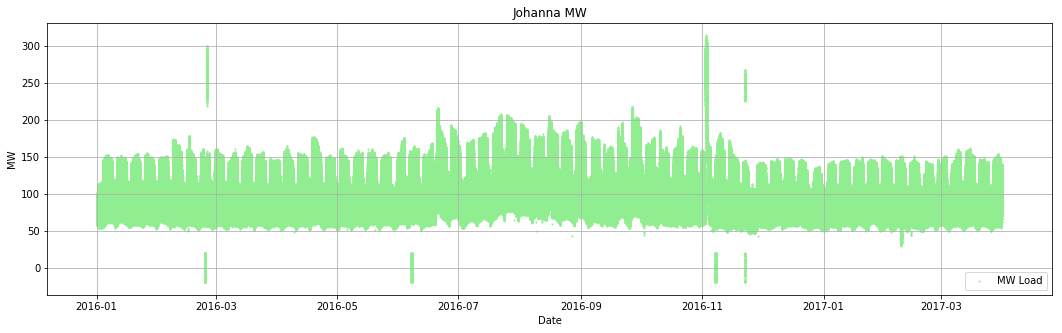

In [107]:
plotMW("Johanna", datetimes, Johanna_MW_load, startDateIndex, endDateIndex)

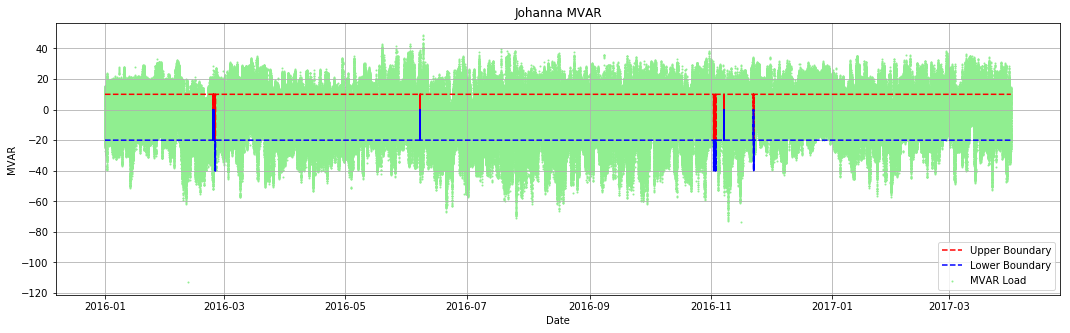

In [108]:
bounds = [(0, 250, -20, 10), (250, 350, -40, -20), (350, 450, -65, -40)]
lower_VAR, upper_VAR = plotMVAR("Johanna", datetimes, Johanna_MW_load, Johanna_MVAR_load, startDateIndex, endDateIndex, bounds)

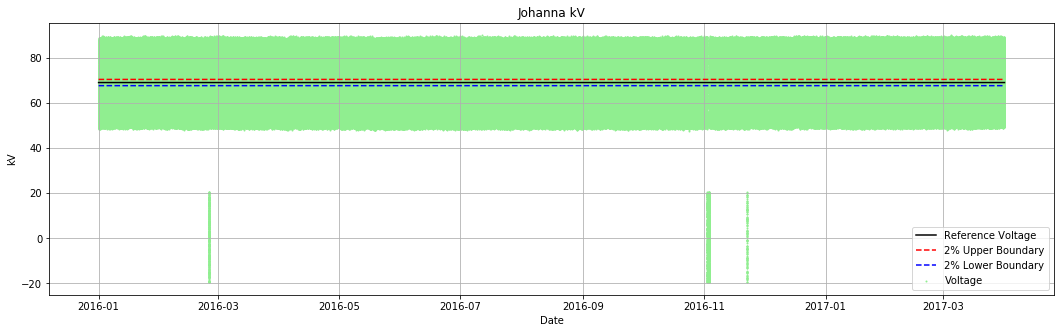

In [109]:
bounds = 69
lower_Volt, upper_Volt = plotVoltage("Johanna", datetimes, Johanna_MW_load, Johanna_Voltage, startDateIndex, endDateIndex, bounds, "all times")

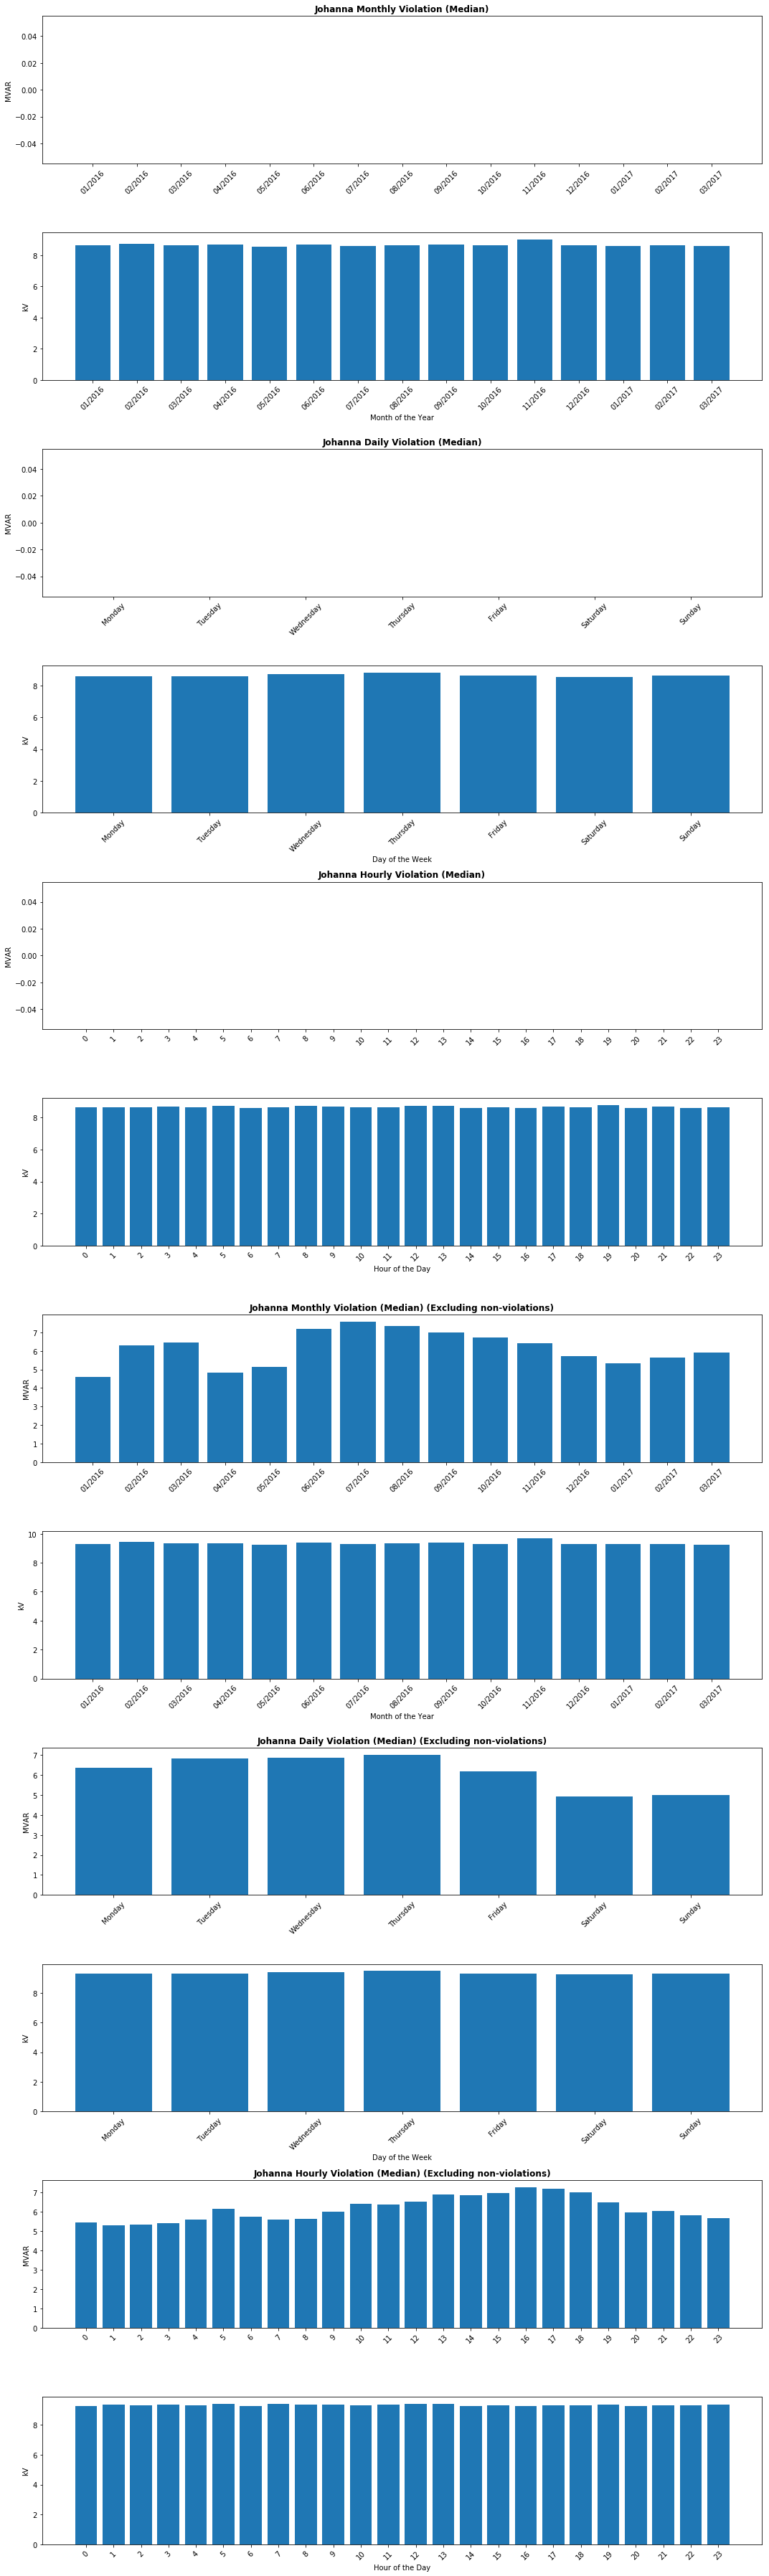

If any of the bars are blank, the median is zero.


In [110]:
plotBreakdown("Johanna", datetimes, Johanna_MVAR_load, Johanna_Voltage, startDateIndex, endDateIndex, lower_VAR, upper_VAR, lower_Volt, upper_Volt)

# 3C. Plotting Data (Voltage and VAR violation in certain periods)

## Springville (Voltage Dependent on MW Load)

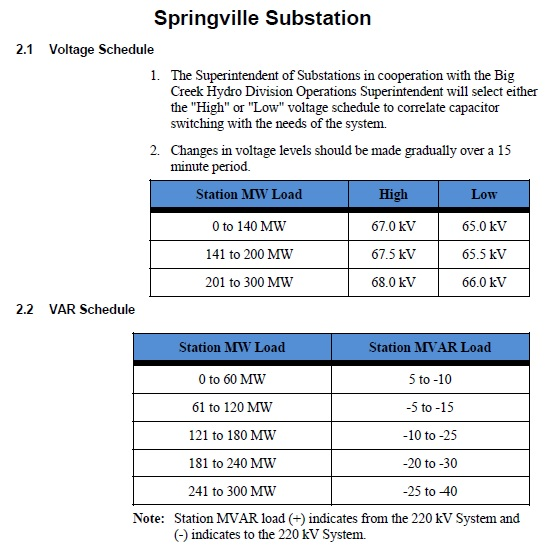

In [111]:
Image("img/SpringvilleSOB.jpg")

In [112]:
start = datetime(2016, 1, 1, 0, 0)
end = datetime(2017, 3, 31, 23, 59)
startDateIndex = computeTableIndex(start)
endDateIndex = computeTableIndex(end)
print("Current Time Period: " + start.strftime('%m/%d/%Y %H:%M') + " to " + end.strftime('%m/%d/%Y %H:%M'))

Current Time Period: 01/01/2016 00:00 to 03/31/2017 23:59


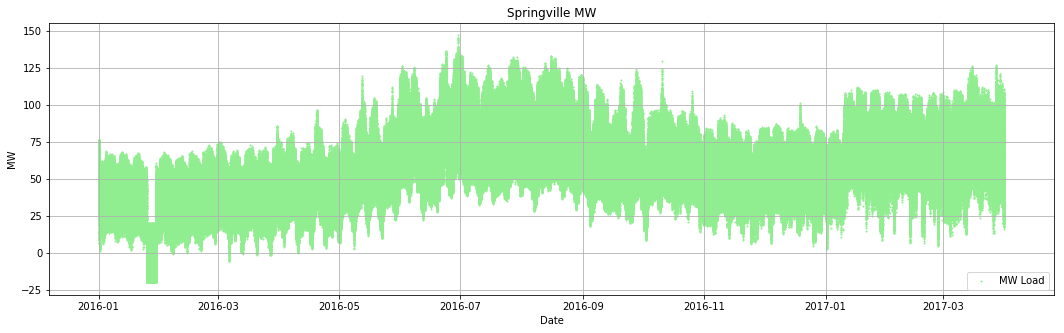

In [113]:
plotMW("Springville", datetimes, Springville_MW_load, startDateIndex, endDateIndex)

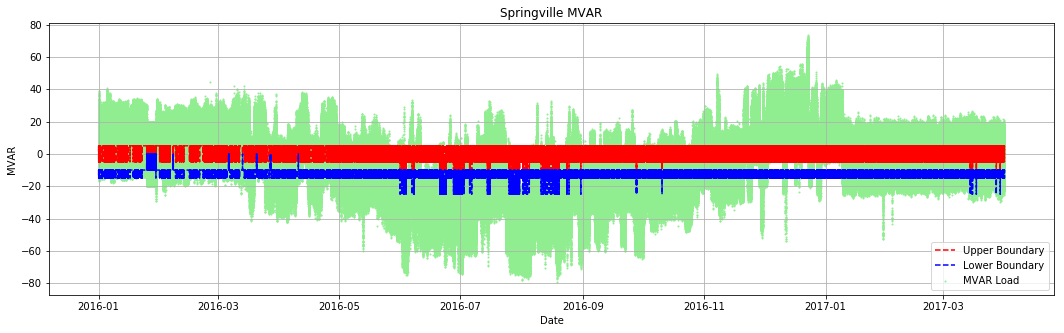

In [114]:
bounds = [(0, 60, -10, 5), (60, 120, -15, -5), (120, 180, -25, -10)]
lower_VAR, upper_VAR = plotMVAR("Springville", datetimes, Springville_MW_load, Springville_MVAR_load, startDateIndex, endDateIndex, bounds)

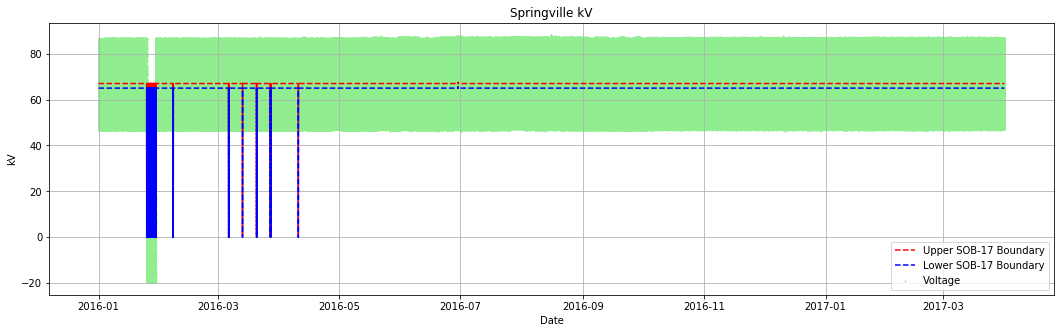

In [115]:
bounds = [(0, 140, 65, 67), (140, 200, 65.5, 67.5), (200, 300, 66, 68)]
lower_Volt, upper_Volt = plotVoltage("Springville", datetimes, Springville_MW_load, Springville_Voltage, startDateIndex, endDateIndex, bounds, "load dependent range")

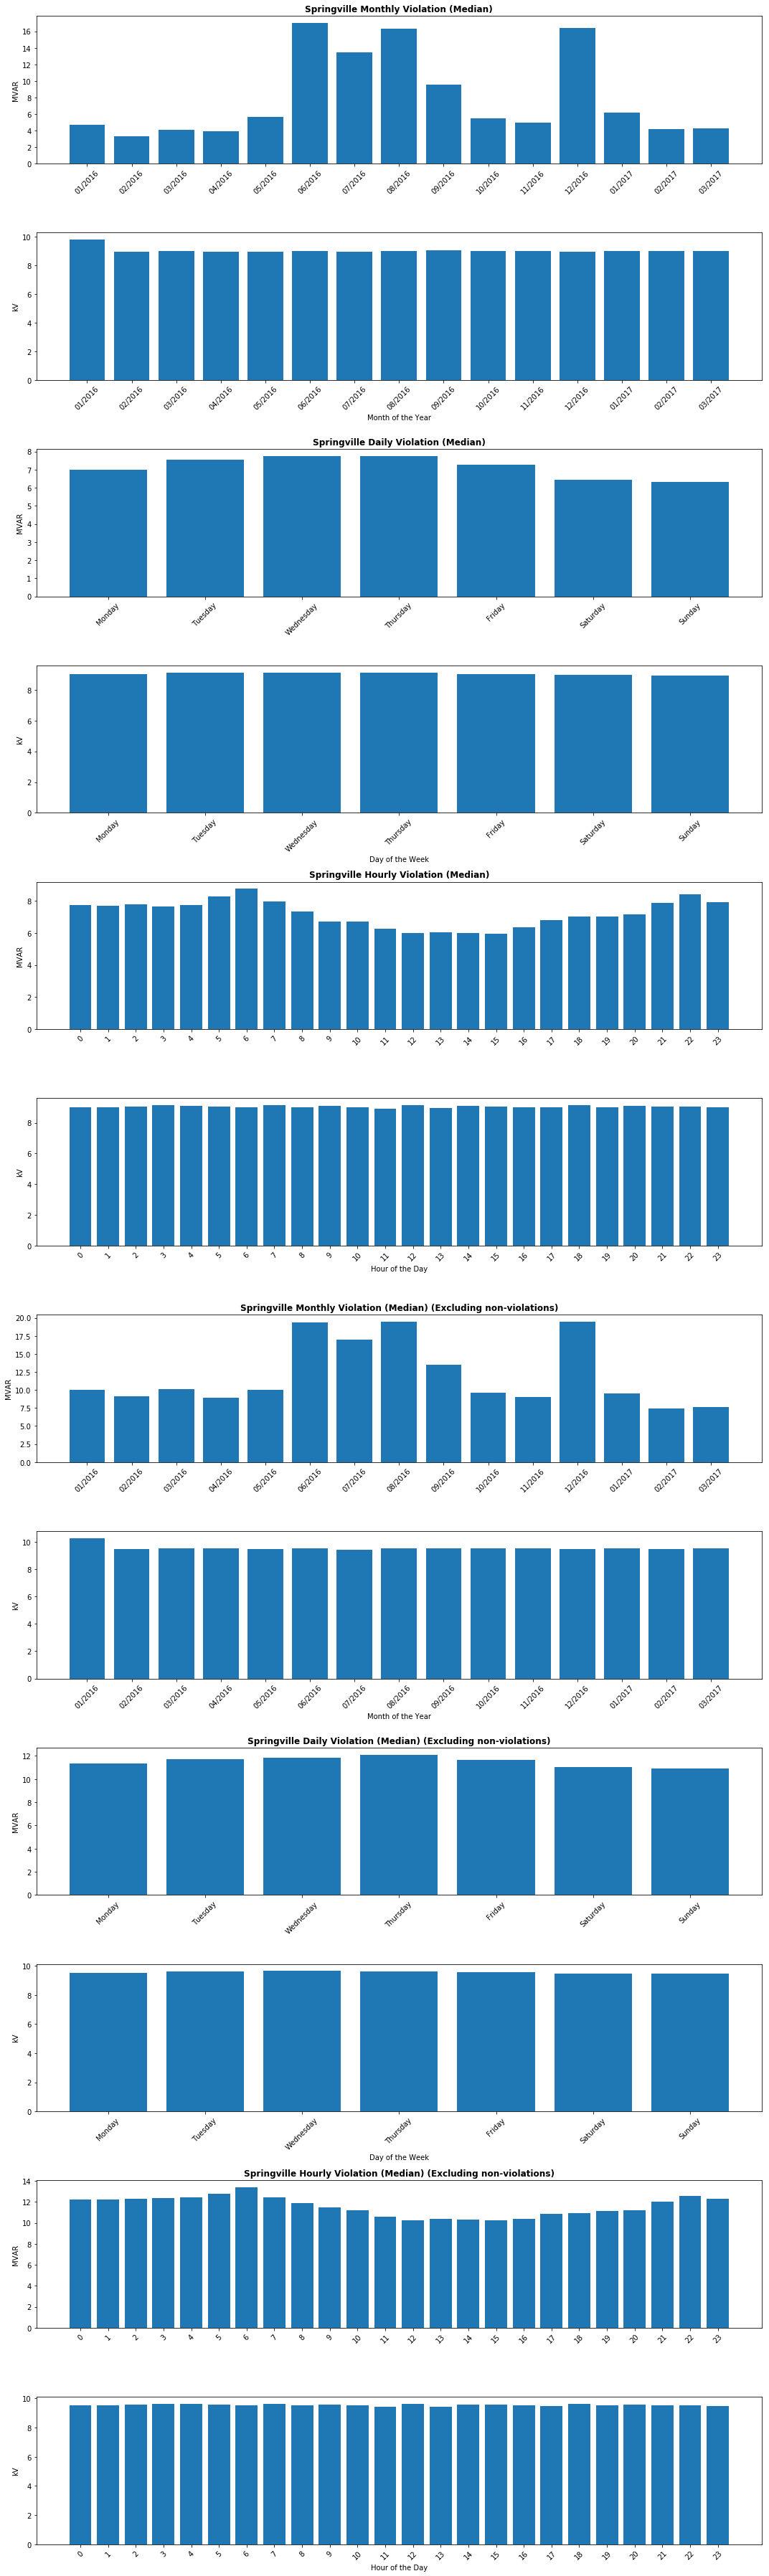

If any of the bars are blank, the median is zero.


In [116]:
plotBreakdown("Springville", datetimes, Springville_MVAR_load, Springville_Voltage, startDateIndex, endDateIndex, lower_VAR, upper_VAR, lower_Volt, upper_Volt)

## Villa Park (Voltage dependent on MW Load)

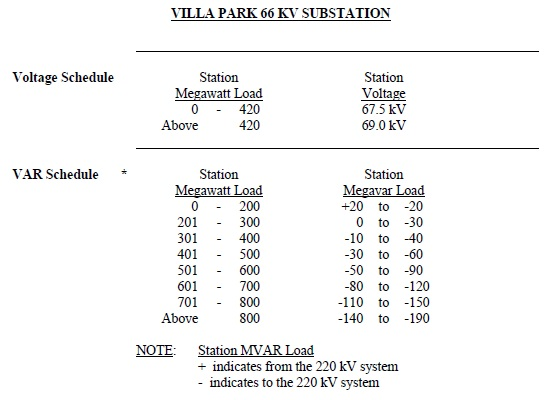

In [117]:
Image("img/VillaParkSOB.jpg")

In [118]:
start = datetime(2016, 1, 1, 0, 0)
end = datetime(2017, 3, 31, 23, 59)
startDateIndex = computeTableIndex(start)
endDateIndex = computeTableIndex(end)
print("Current Time Period: " + start.strftime('%m/%d/%Y %H:%M') + " to " + end.strftime('%m/%d/%Y %H:%M'))

Current Time Period: 01/01/2016 00:00 to 03/31/2017 23:59


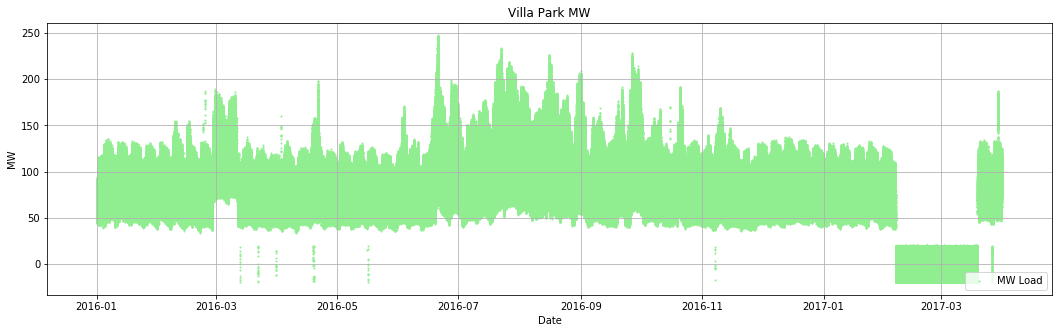

In [119]:
plotMW("Villa Park", datetimes, VillaPark_MW_load, startDateIndex, endDateIndex)

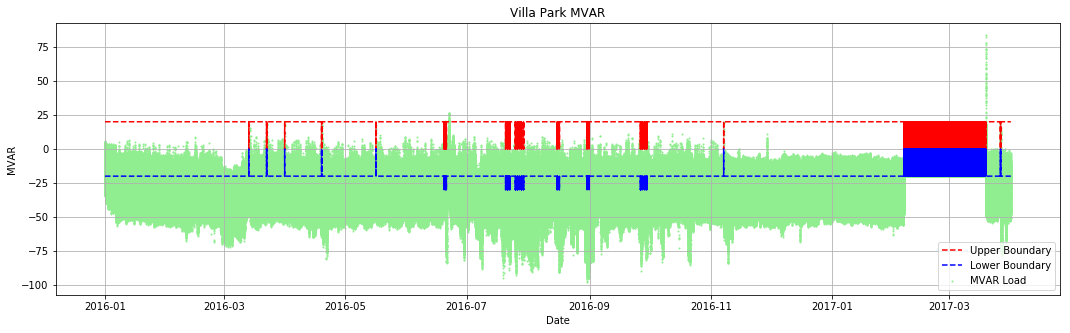

In [120]:
bounds = [(0, 200, -20, 20), (200, 300, -30, 0), (300, 400, -40, -10)]
lower_VAR, upper_VAR = plotMVAR("Villa Park", datetimes, VillaPark_MW_load, VillaPark_MVAR_load, startDateIndex, endDateIndex, bounds)

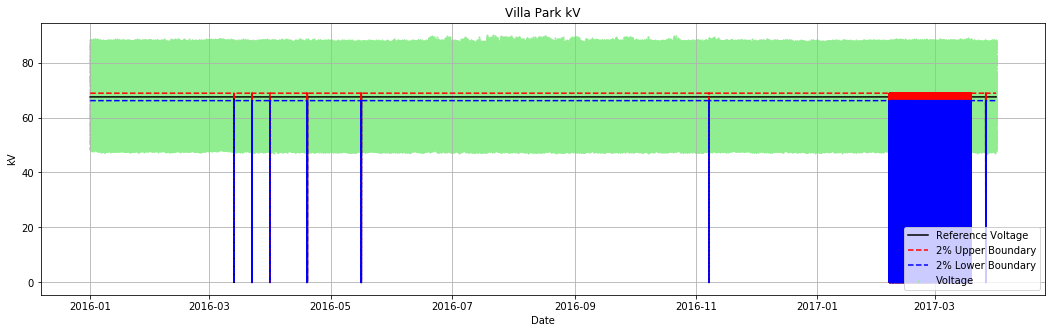

In [121]:
bounds = [(0, 420, 67.5), (420, float('inf'), 69)]
lower_Volt, upper_Volt = plotVoltage("Villa Park", datetimes, VillaPark_MW_load, VillaPark_Voltage, startDateIndex, endDateIndex, bounds, "load dependent")

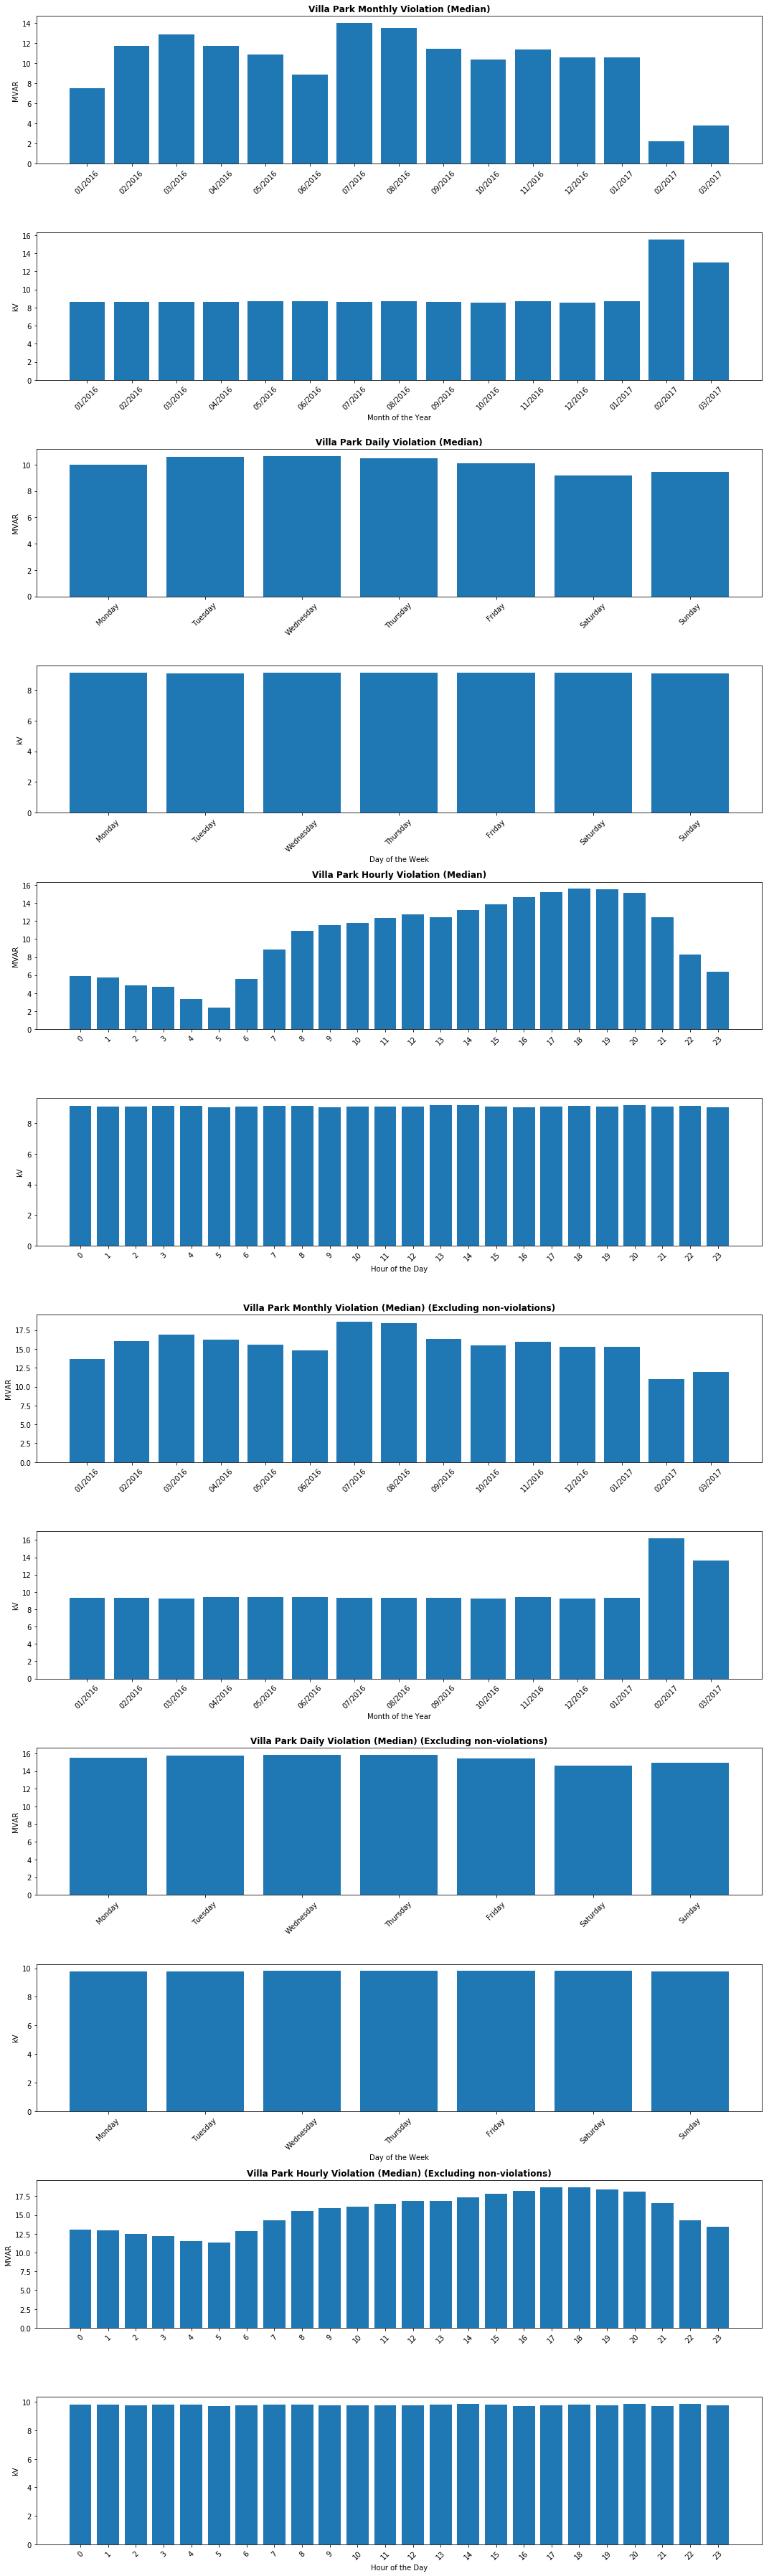

If any of the bars are blank, the median is zero.


In [122]:
plotBreakdown("Villa Park", datetimes, VillaPark_MVAR_load, VillaPark_Voltage, startDateIndex, endDateIndex, lower_VAR, upper_VAR, lower_Volt, upper_Volt)